# **Autoencoder and Resnet Latent Space**

## *1. Dataset Loading and Preprocessing*

### **1.1. Importing Required Libraries**

#### **File Handling & Data Processing**
- `Path`, `os`, `shutil`: Handle file and directory operations.
- `pandas`, `numpy`: Provide tools for data manipulation.
- `pickle`: Serializes and saves Python objects.

#### **Image Processing**
- `PIL.Image`: Handles image loading and processing.
- `torchvision.transforms`: Applies transformations like resizing and normalization.

#### **Deep Learning with PyTorch**
- `torch`: Core PyTorch library for tensor computation and model building.
- `torchvision`: Provides datasets, pre-trained models, and utilities.
- `resnet50, ResNet50_Weights`: Loads the ResNet-50 model with pre-trained weights.


In [4]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from PIL import Image


from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

### **1.2. Dataset Loading and Preprocessing**


This section covers loading the dataset from directories, defining categories, and applying preprocessing transformations.


####  **Dataset Directory Setup**:
  - The dataset directory path is defined dynamically relative to the script's location.
  - The checkpoint directory is also created to save model checkpoints.
  
####  **Categories**:
  - A list of categories is defined. These categories represent different object types like "bottle," "capsule," "screw," etc.

####  **Image Transformation**:
  - A transformation pipeline is defined using `torchvision.transforms.Compose`. The images are resized to 224x224 pixels and converted into PyTorch tensors. This ensures that all images are of the same size and normalized between [0, 1].

####  **Loading Datasets**:
  - The `ImageFolder` class from `torchvision.datasets` is used to load the dataset for both training and testing.
  - Each category has its own subfolder, and within each subfolder, there are separate "train" and "test" directories.
  - The train and test datasets are stored in dictionaries (`train_datasets_dict` and `test_datasets_dict`), indexed by category.
  

In [5]:
# Load the dataset
dataset_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "..\..\..\Dataset")
dataset_dir = os.path.normpath(dataset_dir)
# Define the checkpoint file path
checkpoint_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'Checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)




### **1.3. Directory and Category Definition**

The dataset directory and categories are set up and used for loading specific subsets of data.

####  **Define Dataset Paths**:
  - Paths for training and test images for each category are generated dynamically using the base dataset directory.
####  **Categories**:
  - Categories of objects to be classified are predefined (e.g., "bottle," "carpet," "tile").
  - The `categories` list defines all possible object types for the dataset.


In [6]:
# define the categories
categories = [
    "bottle",
    "cable",
    "capsule",
    "carpet",
    "grid",
    "hazelnut",
    "leather",
    "metal_nut",
    "pill",
    "screw",
    "tile",
    "toothbrush", 
    "transistor",
    "wood",
    "zipper"
]

min_categories = 0
max_categories = 15

### **1.4. Dataset Transformation and Preprocessing**

This section handles the transformation of input images into the appropriate format for model input (resizing and tensor conversion).

#### **Image Transformation Pipeline**:
  - Images are resized to 224x224 pixels using `transforms.Resize((224, 224))`.
  - The images are then converted to PyTorch tensors using `transforms.ToTensor()`.
  - This ensures the images are ready to be used as input to the ResNet model.
  

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()          # Convert the image to a PyTorch tensor and divide by 255.0 (Normalization [0,1])
])


### **1.5. Load Train and Test Datasets for Categories**

This section loads the training and testing datasets for each category using the `ImageFolder` class, which simplifies the loading of image data from directories.

#### **Load Datasets**:
  - For each category, the images are loaded from the respective "train" and "test" subdirectories.
  - The `ImageFolder` class automatically applies the previously defined transformations and loads the images as PyTorch tensors.
  - The datasets for each category are stored in dictionaries (`train_datasets_dict` and `test_datasets_dict`) for easy access.

In [8]:
# Define the path to the training and test images
# Load the train and test datasets using the ImageFolder dataset class
# ImageFolder is a PyTorch dataset class for loading images from a directory
# It automatically loads images from subdirectories and applies transformations to them
# In this case, 'transform' is a transformation applied to each image in the dataset
# It preprocesses the images before they are used for training and testing
# Initialize dictionaries to store datasets for all categories
train_datasets_dict = {}
test_datasets_dict = {}

# Iterate through each category and load the train and test datasets
for category in categories:
    train_image_path = os.path.join(dataset_dir, category, 'train')
    test_image_path = os.path.join(dataset_dir, category, 'test')
    
    train_dataset = ImageFolder(root=train_image_path, transform=transform)
    test_dataset = ImageFolder(root=test_image_path, transform=transform)
    
    train_datasets_dict[category] = train_dataset
    test_datasets_dict[category] = test_dataset

### **1.6. Train / Validation Split**

  - This section splits the training dataset into two subsets: one for training and another for validation.
  - It uses `torch.utils.data.random_split`, which randomly splits a dataset into non-overlapping subsets based on specified proportions.

####  **Splitting the Dataset**:
  - For each category, the dataset is split into 80% for training and 20% for validation.
  - The split is performed using the `random_split` function, which accepts the dataset and a list of subset sizes (`[0.8, 0.2]`).

####  **Storing Train/Validation Subsets**:
  - The train and validation subsets for each category are stored in the dictionary `train_val_split_dict` with keys `'train'` and `'validation'`.


In [9]:
import torch
# Split the dataset into training and validation subsets
# The `torch.utils.data.random_split` function randomly splits a dataset into non-overlapping subsets
# The first argument `good_dataset` is the dataset to be split
# The second argument `[0.8, 0.2]` specifies the sizes of the subsets. Here, 80% for training and 20% for validation.
# Create a dictionary to store train and validation splits for each category
train_val_split_dict = {}
for category in categories:
    train_subset, validation_subset = torch.utils.data.random_split(train_datasets_dict[category], [0.8, 0.2])
    train_val_split_dict[category] = {'train': train_subset, 'validation': validation_subset}

### **1.7. Using DataLoader for Efficient Data Loading During Training**


This section demonstrates how to use `DataLoader` for loading the datasets during training and validation, ensuring efficient batching and shuffling.


####  **Setting the Batch Size**:
  - A batch size of 16 (`BS = 16`) is set for training and validation data loading. This ensures the data is processed in manageable chunks.
  
####  **Creating DataLoaders**:
  - For each category, a `DataLoader` is created for both the training and validation subsets using `train_val_split_dict[category]['train']` and `train_val_split_dict[category]['validation']` respectively.
  - The `DataLoader` handles the batching of images, shuffling, and parallel data loading to speed up training.

####  **Inspecting the Shape of Batches**:
  - A batch of images and their corresponding labels is fetched using `next(iter(train_loaders[category]))`.
  - The shape of the image batch and label batch is printed to understand the dimensions. For example, it might show a shape like `[16, 3, 224, 224]` (16 images, 3 channels, 224x224 pixels).

####  **Calculating Memory Usage**:
  - The memory usage of the image batch is calculated by multiplying the total number of elements in the tensor (`image_batch.numel()`) by the size of each element (`image_batch.element_size()`).
  - The memory usage is printed in kilobytes for a better understanding of how much memory is used by the image batches.


In [10]:
import torch
from torch.utils.data import DataLoader

# Set the batch size
BS = 16

# Create data loaders for training and validation datasets for each category
train_loaders = {}
validation_loaders = {}

for category in categories:
    train_loaders[category] = DataLoader(train_val_split_dict[category]['train'], batch_size=BS, shuffle=True)
    validation_loaders[category] = DataLoader(train_val_split_dict[category]['validation'], batch_size=BS, shuffle=True)

    # Get a batch of images and labels from the training loader
    image_batch, label_batch = next(iter(train_loaders[category]))
    # Print the shape of the input images and labels
    print(f'Shape of input images: {image_batch.shape}')
    print(f'Shape of labels: {label_batch.shape}')

    # Calculate the memory usage
    memory_usage = image_batch.numel() * image_batch.element_size()

    # Print the memory usage
    print(f"Memory usage of the tensor: {memory_usage//1024} KB")

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])
Memory usage of the tensor: 9408 KB
Shape of input i

## *2. Loading a Pretrained ResNet Model*

In the following picture we can see how the pretrained resent model is built. 
The paper "DFR: Deep Feature Reconstruction for Unsupervised Anomaly Segmentation" tells us that we should extract feature from the internal layers. At the end of last layer of block 1 and block 2 for example
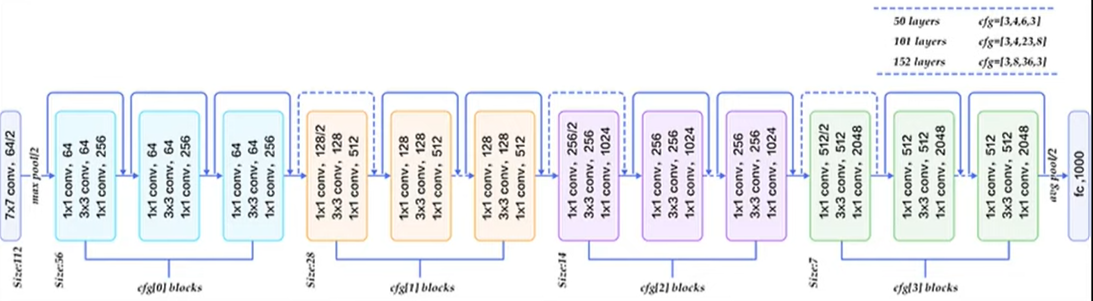


#### **Model Setup**:  
  - A pretrained ResNet50 model is used to extract features from specific layers (`layer2` and `layer3`).
  - The model is set to evaluation mode using `.eval()` to disable dropout and batch normalization updates.
  - All parameters of the model are frozen using `.requires_grad = False` to prevent weight updates during feature extraction.

#### **Feature Extraction**:  
  - Hooks are registered on the last block of `layer2` and `layer3` using `register_forward_hook()`. These hooks extract the feature maps during the forward pass.
  - The `forward()` method performs a pass through the model to obtain feature maps, processes them using an average pooling layer, and then resizes them with an adaptive average pooling layer to ensure consistent spatial dimensions.
  - The feature maps from both layers are concatenated along the channel dimension to create a combined feature map.


### **2.1. Explanation of the `resnet_feature_extractor` class**:

####    **Class Initialization (`__init__`)**:
  - The `resnet_feature_extractor` class inherits from `torch.nn.Module`, which is the base class for all neural network modules in PyTorch.
  - It initializes a pre-trained ResNet-50 model using `resnet50(weights=ResNet50_Weights.DEFAULT)` which loads the model with the default weights from ImageNet.
  - The model is set to evaluation mode using `self.model.eval()`. This disables dropout and batch normalization, as we are using the model for inference rather than training.
  - Freezes all parameters of the model with `param.requires_grad = False` to prevent them from being updated during the forward pass.

####    **Hook Function**:
  - A hook function `hook` is defined within the class, which is responsible for extracting the feature maps from the intermediate layers of the ResNet model during the forward pass.
  - The hook function is registered on the last block of `block 1` and `block 2` using `register_forward_hook`. This means that feature maps from these layers will be extracted and saved in `self.features` during the forward pass.

####    **Forward Method (`forward`)**:
  - The forward method processes the input through the ResNet model and extracts the feature maps.
  - The `self.features` list is initialized to store the feature maps.
  - The model performs a forward pass using `with torch.no_grad()` to prevent the computation of gradients.
  - After the forward pass, an average pooling layer `self.avg` with kernel size 3 and stride 1 is applied to the extracted feature maps from the hooks.
  - The spatial size (height and width) of the feature map from `block 1` is used to define an adaptive average pooling layer (`self.resize`) to resize the feature maps to the same size.
  - The resized feature maps from `block 1` and `block 2` are concatenated along the channel dimension to form a final feature map.
  - The concatenated feature map (`patch`) is returned as the output.


  - The `resnet_feature_extractor` class extracts feature maps from two internal layers (`block 1` and `block 2`) of a pre-trained ResNet-50 model.
  - The model is set to evaluation mode, and its parameters are frozen to prevent updates during the forward pass.
  - A hook function is used to capture the feature maps, and the forward method processes and concatenates them before returning the final feature map.



In [ ]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained ResNet model."""
        super(resnet_feature_extractor, self).__init__()

        # Load a pretrained ResNet-50 model with default ImageNet weights
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
        self.model.eval()

        # Freeze all parameters in the ResNet model to prevent them from being updated
        for param in self.model.parameters():
            param.requires_grad = False

        # Hook function to extract feature maps during the forward pass
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map in self.features."""
            self.features.append(output)

        # Register the hook on the last layer of block 1 to extract its output
        self.model.layer2[-1].register_forward_hook(hook)

        # Register the hook on the last layer of block 2 to extract its output
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):
        """Forward method to process the input and extract concatenated feature maps."""
        
        # Initialize the features list to store outputs from the hooks
        self.features = []

        # Perform a forward pass through the ResNet model without computing gradients
        with torch.no_grad():
            _ = self.model(input)

        # Define a 2D average pooling layer with kernel size 3 and stride 1
        self.avg = torch.nn.AvgPool2d(3, stride=1)

        # Get the spatial size (height, width) of the feature map from layer2
        fmap_size = self.features[0].shape[-2]  # Assume all feature maps have the same size

        # Define an adaptive average pooling layer to resize feature maps to the same size
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        # Resize and process the feature maps from layer2 and layer3
        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]

        # Concatenate the processed feature maps along the channel dimension
        patch = torch.cat(resized_maps, 1)

        # Return the concatenated feature maps as the final output
        return patch


## *3. ResNet Feature Extractor*

### **3.1. Initializing the feature extractor:**
`backbone = resnet_feature_extractor()`: Initializes the custom ResNet feature extractor model.
  
#### **Creating an empty list to store results:**
  - `results = []`: Initializes an empty list to store results for each category.

#### **Iterating over categories:**
  - `for category in categories[min_categories:max_categories]`: Loops through the categories specified by `min_categories` and `max_categories`.

#### **Processing the first image in each category:**
  - `image_path, _ = train_datasets_dict[category].samples[0]`: Gets the path of the first image in the category.
  - `image = Image.open(image_path)`: Opens the image using PIL.
  - `if image.mode != 'RGB': image = image.convert('RGB')`: Converts grayscale images to RGB format if necessary.

#### **Applying transformations to the image:**
  - `image = transform(image).unsqueeze(0)`: Applies transformations (like resizing) and adds a batch dimension to the image.

#### **Feature extraction from the image:**
  - `feature = backbone(image)`: Extracts the feature map using the `resnet_feature_extractor`.

#### **Storing the results:**
  - The shape of the feature map from `block 1`, `block 2`, and the concatenated feature maps are stored in a dictionary.
  - The dictionary is appended to the `results` list.

#### **Creating a DataFrame to display the results:**
  - `df_results = pd.DataFrame(results)`: Converts the results list into a pandas DataFrame for display.
  - `df_results`: Displays the feature map shapes for each category.


In [14]:
# Initialize the resnet_feature_extractor
backbone = resnet_feature_extractor()
# Create an empty list to store the results
results = []

# Iterate through each category and process the first test image
for category in categories[min_categories:max_categories]:
    # Get the first test image path from the current category
    image_path, _ = train_datasets_dict[category].samples[0]
    
    # Open the image using PIL
    image = Image.open(image_path)
    
    # Convert grayscale image to RGB by repeating the single channel three times
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Apply the transformation and add a batch dimension
    image = transform(image).unsqueeze(0)
    
    # Extract features using the backbone
    feature = backbone(image)
    
    # Append the results to the list
    results.append({
        "Category": category,
        "Feature map from layer2": backbone.features[0].shape,
        "Feature map from layer3": backbone.features[1].shape,
        "Concatenated feature shape": feature.shape
    })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results
    
   


Category Feature map from layer2 Feature map from layer3  \
0       bottle        (1, 512, 28, 28)       (1, 1024, 14, 14)   
1        cable        (1, 512, 28, 28)       (1, 1024, 14, 14)   
2      capsule        (1, 512, 28, 28)       (1, 1024, 14, 14)   
3       carpet        (1, 512, 28, 28)       (1, 1024, 14, 14)   
4         grid        (1, 512, 28, 28)       (1, 1024, 14, 14)   
5     hazelnut        (1, 512, 28, 28)       (1, 1024, 14, 14)   
6      leather        (1, 512, 28, 28)       (1, 1024, 14, 14)   
7    metal_nut        (1, 512, 28, 28)       (1, 1024, 14, 14)   
8         pill        (1, 512, 28, 28)       (1, 1024, 14, 14)   
9        screw        (1, 512, 28, 28)       (1, 1024, 14, 14)   
10        tile        (1, 512, 28, 28)       (1, 1024, 14, 14)   
11  toothbrush        (1, 512, 28, 28)       (1, 1024, 14, 14)   

   Concatenated feature shape  
0           (1, 1536, 28, 28)  
1           (1, 1536, 28, 28)  
2           (1, 1536, 28, 28)  
3           (1, 1536, 28, 28)  
4           (1, 1536, 28, 28)  
5           (1, 1536, 28, 28)  
6           (1, 1536, 28, 28)  
7           (1, 1536, 28, 28)  
8           (1, 1536, 28, 28)  
9           (1, 1536, 28, 28)  
10          (1, 1536, 28, 28)  
11          (1, 1536, 28, 28)

### **3.2. Selecting random indices for feature maps**
`indices = torch.randperm(64)[:10]`: Generates a random permutation of 64 and selects the first 10 indices for feature map visualization.

#### **Creating subplots for visualization:**
  - `fig, axes = plt.subplots(2, 5, figsize=(15, 6))`: Creates a 2x5 grid of subplots for displaying the feature maps.

#### **Looping through and visualizing feature maps:**
  - `for i, idx in enumerate(indices)`: Loops through the randomly selected indices.
  - `row = i // 5` and `col = i % 5`: Determines the row and column positions for the subplot grid.
  - `axes[row, col].imshow(feature[0, idx].detach().cpu(), cmap='gray')`: Displays each selected feature map in grayscale.
  - `axes[row, col].set_title(f'Feature Map {idx}')`: Sets the title of each subplot to indicate the feature map index.
  - `axes[row, col].axis('off')`: Hides the axis for cleaner visualization.

#### **Final adjustments and display:**
  - `plt.tight_layout()`: Adjusts the layout to prevent overlapping titles and images.
  - `plt.show()`: Displays the feature maps in the plot.


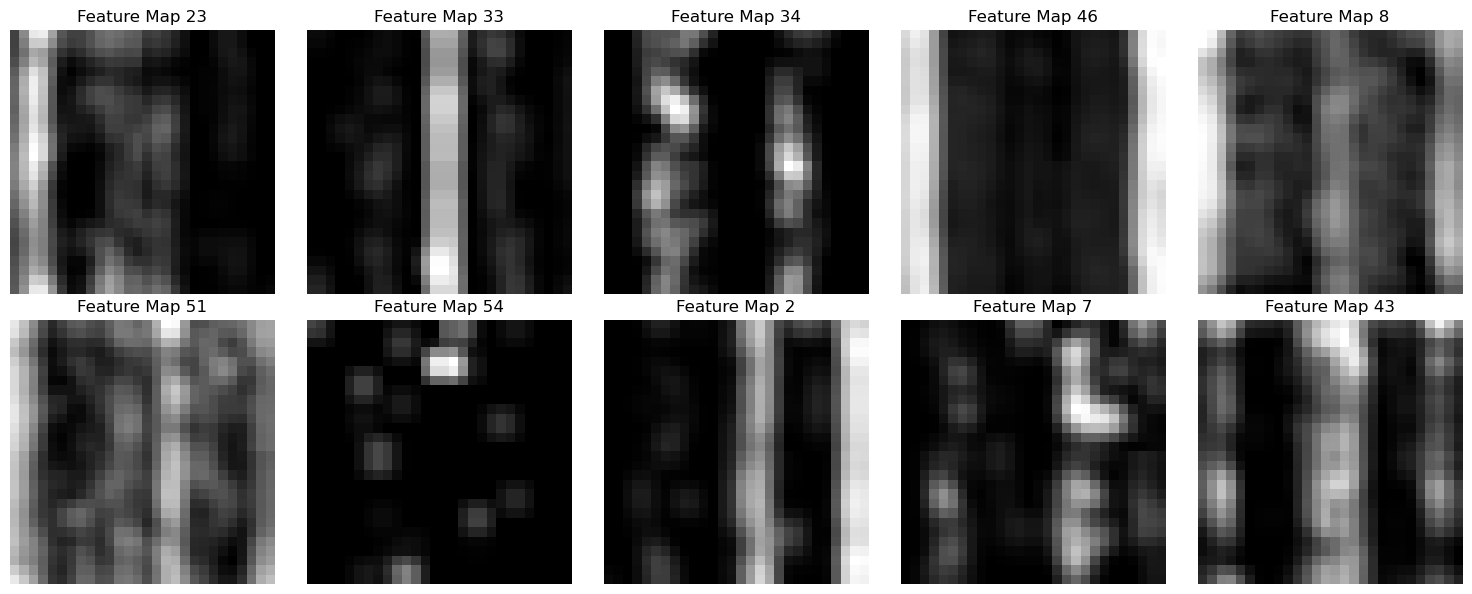

In [11]:

# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

## *4. The Autoencoder Model*

In the following autoencoder the batchnorm is set to true. Batch Normalization (BatchNorm) is a technique used to improve the training of deep neural networks. It normalizes the inputs of each layer so that they have a mean of zero and a standard deviation of one. This helps to stabilize and accelerate the training process by reducing internal covariate shift, which is the change in the distribution of network activations due to the updates of the parameters during training.


#### Key Benefits of Batch Normalization:
- Stabilizes Learning: By normalizing the inputs to each layer, BatchNorm helps to stabilize the learning process and allows for higher learning rates.
- Reduces Sensitivity to Initialization: BatchNorm reduces the sensitivity of the network to the initial weights, making the training process more robust.
- Regularization Effect: BatchNorm has a slight regularization effect, which can reduce the need for other forms of regularization like dropout.

#### How Batch Normalization Works:
- Normalization: For each mini-batch, compute the mean and variance of the inputs.
- Scaling and Shifting: Normalize the inputs using the computed mean and variance, and then scale and shift the normalized values using learnable parameters (gamma and beta).


### **4.1. Class Definition**
`class FeatCAE(nn.Module)`: Defines the `FeatCAE` class, a convolutional autoencoder that inherits from `nn.Module`.

#### **`__init__` Method:**
  - `def __init__(self, in_channels=1000, latent_dim=50, use_bn=True)`: Initializes the model with default input channels, latent space dimension, and whether to use BatchNorm.
    - `in_channels`: Number of input channels (default is 1000).
    - `latent_dim`: Latent space dimension (default is 50).
    - `use_bn`: Flag to include Batch Normalization layers (default is True).

#### **Encoder:**
  - The encoder is composed of 3 convolutional layers with optional Batch Normalization and ReLU activation:
    - `nn.Conv2d(in_channels, latent_dim * 4, kernel_size=1, stride=1, padding=0)`: First convolution reducing the input to `latent_dim * 4`.
    - `nn.BatchNorm2d(latent_dim * 4) if use_bn else nn.Identity()`: Optional BatchNorm layer.
    - `nn.ReLU(inplace=True)`: ReLU activation.
    - Similar layers follow with decreasing channel size to `latent_dim` in the final encoder layer.

#### **Decoder:**
  - The decoder mirrors the encoder's structure:
    - It starts with `latent_dim` channels and progressively increases the number of channels to match the original `in_channels`.
    - Each layer is followed by optional BatchNorm and ReLU activation.

#### **Forward Method:**
  - `def forward(self, x)`: Defines how the input is processed:
    - The input `x` is encoded to a latent space and then decoded back to the original input dimensions.
    - The reconstructed input is returned as output.


In [15]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""
    def __init__(self, in_channels=1000, latent_dim=50, use_bn=True): 
        """
        Initializes the FeatCAE model.
        Args:
            in_channels (int): Number of input channels. Default is 1000.
            latent_dim (int): Dimension of the latent space. Default is 50.
            use_bn (bool): Whether to use Batch Normalization layers. Default is True.  # use_bn is a boolean flag to include BatchNorm layers
        """
        super(FeatCAE, self).__init__()

        # Encoder: Reduce to 3 Conv2d layers with optional BatchNorm and ReLU
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, latent_dim * 4, kernel_size=1, stride=1, padding=0),  # First convolutional layer
            nn.BatchNorm2d(latent_dim * 4) if use_bn else nn.Identity(),  # Optional BatchNorm layer
            nn.ReLU(inplace=True),  # ReLU activation
            
            nn.Conv2d(latent_dim * 4, latent_dim * 2, kernel_size=1, stride=1, padding=0),  # Second convolutional layer
            nn.BatchNorm2d(latent_dim * 2) if use_bn else nn.Identity(),  # Optional BatchNorm layer
            nn.ReLU(inplace=True),  # ReLU activation
            
            nn.Conv2d(latent_dim * 2, latent_dim, kernel_size=1, stride=1, padding=0)  # Third convolutional layer
        )

        # Decoder: Mirror the encoder structure for reconstruction
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim * 2, kernel_size=1, stride=1, padding=0),  # First convolutional layer
            nn.BatchNorm2d(latent_dim * 2) if use_bn else nn.Identity(),  # Optional BatchNorm layer
            nn.ReLU(inplace=True),  # ReLU activation
            
            nn.Conv2d(latent_dim * 2, latent_dim * 4, kernel_size=1, stride=1, padding=0),  # Second convolutional layer
            nn.BatchNorm2d(latent_dim * 4) if use_bn else nn.Identity(),  # Optional BatchNorm layer
            nn.ReLU(inplace=True),  # ReLU activation
            
            nn.Conv2d(latent_dim * 4, in_channels, kernel_size=1, stride=1, padding=0)  # Third convolutional layer
        )

    def forward(self, x):
        # Pass through encoder and decoder
        x = self.encoder(x)  # Encode the input
        x = self.decoder(x)  # Decode the encoded input
        return x  # Return the reconstructed output


### **4.2. Imports and Initializations:**
  - `from collections import defaultdict`: Imports `defaultdict` to handle the training history for each category.
  - `models_dict`: A dictionary to store the trained models for each category.
  - `history_dict`: A defaultdict that stores training and validation losses for each category during training.
  - `num_epochs`: Number of epochs to train the model (default is 100).
  - `patience`: Early stopping patience, triggers stopping if validation loss does not improve after `patience` epochs.

### **4.3. Model Training Loop:**
  - The model is trained for each category in `categories[min_categories:max_categories]`:
#### **Model and Optimizer Setup:**
  - `model = FeatCAE(in_channels=1536, latent_dim=100).cuda()`: Initializes and moves the model to GPU.
  - `backbone.cuda()`: Moves the feature extractor (backbone) to GPU.
  - `criterion = torch.nn.MSELoss()`: Defines the Mean Squared Error loss function.
  - `optimizer = optim.Adam(model.parameters(), lr=0.001)`: Sets the Adam optimizer with a learning rate of 0.001.

#### **Epoch Loop:**
  - For each epoch, the model is trained on the batch of images and validated using the validation data:
  - Training involves feature extraction, forward pass through the model, loss calculation, backward propagation, and optimizer step.
  - Validation involves calculating the validation loss for the current epoch.

#### **History and Loss Logging:**
  - `history_dict[category]['train_loss'].append(loss.item())`: Logs the training loss for each epoch.
  - `history_dict[category]['val_loss'].append(val_loss_avg)`: Logs the validation loss for each epoch.
  - The training and validation losses are printed at the end of each epoch.

#### **Early Stopping Check:**
  - If the validation loss improves, the best model parameters are saved.
  - If there is no improvement in validation loss for `patience` epochs, early stopping is triggered.

#### **Model Saving and Visualization:**
  - The best model parameters are stored in `models_dict` for each category.
  - A plot showing training and validation loss curves is displayed for each category.


#### **Checkpoint savings:**
  - `checkpoint`: Stores the trained models and training history for all categories.


In [16]:
from collections import defaultdict

# Dictionary to store models, losses, and training history
models_dict = {}
history_dict = defaultdict(lambda: {'train_loss': [], 'val_loss': []})
num_epochs = 100
patience = 2  # early stopping patience

for category in tqdm(categories[min_categories:max_categories], desc='Categories'):
    print(f"\nTraining model for {category}")
    
    model = FeatCAE(in_channels=1536, latent_dim=100).cuda() #mode to cuda
    backbone.cuda()
    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    no_improvement_count = 0
    best_model_params = None
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        for img, _ in train_loaders[category]:
            img = img.cuda()
            features = backbone(img)  # Extract features using the backbone
            output = model(features)
            loss = criterion(output, features)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            val_loss_sum = 0.0
            num_batches = 0
            for img, _ in validation_loaders[category]:
                img = img.cuda()
                features = backbone(img)  # Extract features using the backbone
                output = model(features)
                val_loss_sum += criterion(output, features).item()
                num_batches += 1
            val_loss_avg = val_loss_sum / num_batches
            
        history_dict[category]['train_loss'].append(loss.item())
        history_dict[category]['val_loss'].append(val_loss_avg)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss_avg:.4f}')
        
        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            no_improvement_count = 0
            best_model_params = model.state_dict()
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print("Early stopping triggered")
                break
    
    # Store the best model parameters for this category
    if best_model_params is not None:
        models_dict[category] = best_model_params
    else:
        models_dict[category] = model.state_dict()
    
    plt.figure(figsize=(10, 5))
    plt.plot(history_dict[category]['train_loss'], label='Training Loss')
    plt.plot(history_dict[category]['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {category}')
    plt.legend()
    plt.show()

checkpoint = {
    'models': models_dict,
    'history': history_dict
}



Categories:   0%|          | 0/12 [00:00<?, ?it/s]


Training model for bottle


Categories:   0%|          | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt: 

### **4.5. Saving the Best Model:**
  - The code iterates through the `models_dict`, which contains the best model parameters for each category.
  - For each category:
    - The model's parameters are saved as a checkpoint in the `checkpoint_dir` directory with the filename `best_model_{category}.pth`.
    - The model is saved using `torch.save(model_params, checkpoint_path)`.
    - A message is printed to confirm that the best model for the category has been saved.

### **4.6. Loading the Best Models:**
  - The code loads the best models for each category from their checkpoint files:
    - An empty dictionary `loaded_models` is initialized to store the models.
    - For each category in `categories[min_categories:max_categories]`:
      - The checkpoint path is constructed to point to the saved model file.
      - The model is instantiated and moved to GPU using `.cuda()`.
      - The saved model's state dictionary is loaded with `model.load_state_dict(torch.load(checkpoint_path))`.
      - The model is set to evaluation mode with `model.eval()` for inference.
    - The loaded model is stored in the `loaded_models` dictionary using the category as the key.
    - A confirmation message is printed indicating that all models have been loaded successfully.


In [14]:
'''# Save the best model of each category as a checkpoint
for category, model_params in models_dict.items():
    checkpoint_path = os.path.join(checkpoint_dir, f'best_model_{category}.pth')
    torch.save(model_params, checkpoint_path)
    print(f"Saved best model for {category} at {checkpoint_path}")'''

Saved best model for bottle at c:\Users\peppe\Desktop\MVTEC_Anomaly_detection\Preliminary study\Coding_PyTorch\Autoencoder using resnet\Checkpoints\best_model_bottle.pth


In [17]:
import torch
import os

# Initialize a dictionary to store the loaded models
loaded_models = {}

# Load each best model for every category
for category in categories[min_categories:max_categories]:
    checkpoint_path = os.path.join(checkpoint_dir, f'best_model_{category}.pth')
    model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    loaded_models[category] = model

print("All best models have been loaded successfully.")

All best models have been loaded successfully.


C:\Users\peppe\AppData\Local\Temp\ipykernel_47064\3186768969.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


## *5. Prediction of Heatmap*

#### **Setting Up the Plot Layout:**
  - `num_categories` calculates the number of categories to be processed.
  - `cols` and `rows` are used to determine the number of columns and rows in the plot grid, ensuring the layout fits the number of categories.
  - `fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))` initializes the subplot grid, adjusting the size based on the number of columns and rows.
  - `axes = axes.flatten()` flattens the axes for easy indexing.

#### **Loading the Models and Moving Them to GPU:**
  - The `backbone` and all loaded models are moved to the GPU using `.cuda()`.

#### **Processing Each Category:**
  - The code iterates over each category in `categories[min_categories:max_categories]`:
    - The test image is loaded, converted to RGB if needed, and transformed using the `transform` function. The image is moved to GPU.
    - The `backbone` model is used to extract features from the image.
    - The corresponding model for the category is used to reconstruct the features.
    - The reconstruction error is calculated as the squared difference between the features and the reconstructed output.
    - The error map is resized to `(224, 224)` using bilinear interpolation.

#### **Displaying the Segmentation Maps:**
  - The segmentation map (reconstruction error heatmap) is displayed using `imshow()` with the 'jet' colormap.
  - The subplot title is set to `f"Segmentation Map for {category}"`.
  - The axis for each subplot is turned off using `ax.axis('off')`.

#### **Handling Unused Subplots:**
  - If there are unused subplots (i.e., if the number of categories doesn't fit perfectly into the grid), their axes are hidden.

#### **Displaying the Plot:**
  - `plt.tight_layout()` adjusts the subplot layout to prevent overlap.
  - `plt.show()` displays the final plot with segmentation maps for each category.


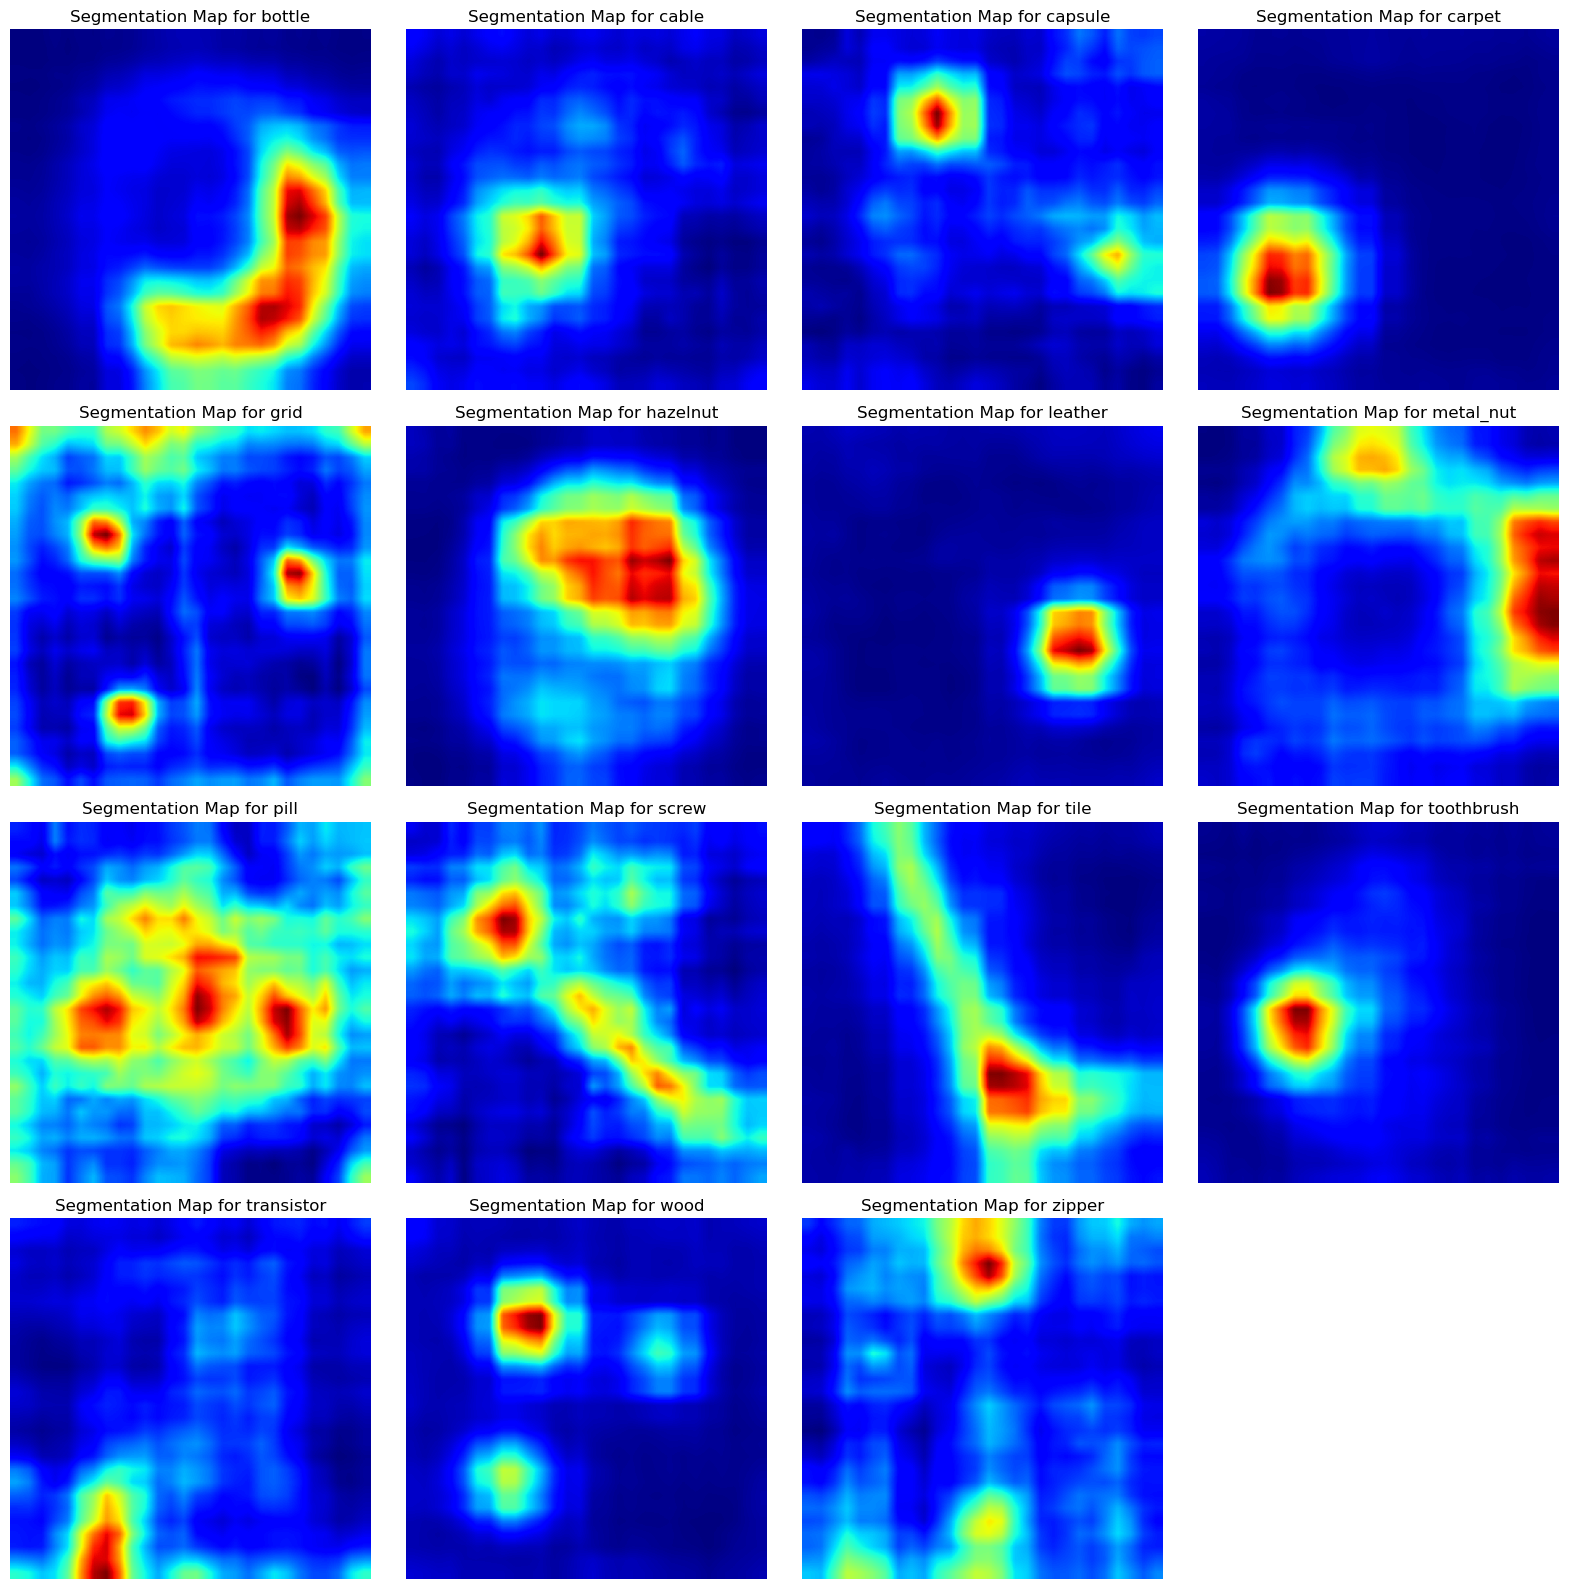

In [19]:
import math

num_categories = max_categories - min_categories
cols = 4
rows = math.ceil(num_categories / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

# Ensure the backbone and loaded models are on the GPU
backbone.cuda()
for category in categories[min_categories:max_categories]:
    loaded_models[category].cuda()

for idx, category in enumerate(categories[min_categories:max_categories]):
    image = Image.open(test_datasets_dict[category][0])
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image).unsqueeze(0).cuda()  # Move the image to GPU

    with torch.no_grad():
        features = backbone(image)
        recon = loaded_models[category](features)

    recon_error = ((features - recon) ** 2).mean(axis=(1)).unsqueeze(0)

    segm_map = torch.nn.functional.interpolate(
        recon_error,
        size=(224, 224),
        mode='bilinear'
    )

    axes[idx].imshow(segm_map.squeeze().cpu().numpy(), cmap='jet')
    axes[idx].set_title(f"Segmentation Map for {category}")
    axes[idx].axis('off')

# Hide any unused subplots
for ax in axes[num_categories:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## *6. Train Images*

### **6.1. Definition of Decision Function**

#### **Function**: `decision_function(segm_map)`
  - **Purpose**: This function calculates the mean of the top 10 values from each segmentation map.
  - **Input**: 
    - `segm_map`: A tensor containing segmentation maps. Each map is a 2D matrix (height, width).
#### **Steps**:
  1. **Initialize an empty list**: `mean_top_10_values` to store the top 10 mean values for each map.
  2. **Iterate through each map** in `segm_map`.
  3. **Flatten the tensor**: Reshape each 2D segmentation map into a 1D tensor to easily sort its values.
  4. **Sort the tensor** in descending order to bring the largest values to the front.
  5. **Take the top 10 values** from the sorted tensor.
  6. **Calculate the mean of the top 10 values**.
  7. **Append the mean** to the `mean_top_10_values` list.
#### **Output**: 
  - Returns a tensor containing the mean of the top 10 values from each segmentation map, stacked along a new dimension.


In [20]:
def decision_function(segm_map):  

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

### **6.2. Anomaly detection using reconstruction error**

This code evaluates reconstruction errors for different categories using the trained models and computes anomaly scores based on the difference between features and reconstructed outputs.

#### **Steps**:
  1. **Set model to evaluation mode**: `model.eval()` ensures that dropout and batch normalization layers behave appropriately during inference.
  2. **Initialize dictionary**: `RECON_ERROR = {}` is used to store the reconstruction errors for each category.
  3. **Iterate over categories**: `for category in categories[min_categories:max_categories]:` iterates over the selected categories to process the images.
  4. **Initialize list**: `category_recon_error = []` to collect reconstruction errors for each batch in the category.
  5. **Loop through batches in `train_loaders[category]`**:
    - For each batch, the following operations occur:
      1. **Feature extraction**: `features = backbone(data.cuda()).squeeze()` extracts features from the input data using the pretrained backbone model.
      2. **Reconstruction**: `recon = loaded_models[category](features)` reconstructs the input features using the autoencoder model.
      3. **Reconstruction error**: The squared difference between the features and reconstruction is computed. `segm_map = ((features - recon) ** 2).mean(axis=(1))[:, 3:-3, 3:-3]` calculates the mean squared error along the feature dimension and discards the edges of the image to focus on the central region.
      4. **Anomaly score**: `anomaly_score = decision_function(segm_map)` computes the anomaly score using the `decision_function` based on the top 10 values in the segmentation map.
  6. **Store results**: After processing all batches for the category, the anomaly scores are appended to the `category_recon_error` list and then stored in the `RECON_ERROR` dictionary for each category.
  
#### **Output**:
  - `RECON_ERROR`: A dictionary where the key is the category name, and the value is an array containing the anomaly scores (reconstruction errors) for all processed images in that category.


In [21]:
model.eval()

RECON_ERROR = {}

for category in categories[min_categories:max_categories]:  # Process only the first 2 categories
    category_recon_error = []
    
    for data, _ in train_loaders[category]:
        with torch.no_grad():
            features = backbone(data.cuda()).squeeze()
            # Forward pass
            recon = loaded_models[category](features)
        # Compute the loss
        segm_map = ((features - recon) ** 2).mean(axis=(1))[:, 3:-3, 3:-3]  # neglect the edges of the image
        anomaly_score = decision_function(segm_map)
        # anomaly_score = segm_map.mean(axis=(1, 2))
        
        category_recon_error.append(anomaly_score)
    
    RECON_ERROR[category] = torch.cat(category_recon_error).cpu().numpy()

### **6.3. Plotting reconstruction error histograms with best threshold**

This code calculates and visualizes the best threshold for anomaly detection for each category based on reconstruction errors and plots histograms of those errors.

#### **Steps**:
   1. **Initialize dictionary**: `best_thresholds = {}` to store the best threshold for each category.
   2. **Determine number of rows and columns for subplots**: 
   - `num_categories = len(RECON_ERROR)` determines how many categories exist.
   - `cols = 4` and `rows = math.ceil(num_categories / cols)` compute the number of rows and columns for the subplot grid.
   3. **Create subplots**: `fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))` creates a grid of subplots to visualize histograms for each category.
   4. **Iterate through reconstruction errors**:
   - For each category (`category, errors`), calculate the best threshold using the formula `threshold = np.mean(errors) + 3 * np.std(errors)`, which is based on the assumption that the majority of normal data points fall within 3 standard deviations from the mean.
   - Store the threshold for each category in the `best_thresholds` dictionary.
   5. **Plot histograms**:
   - `axes[idx].hist(errors, bins=50, alpha=0.7)` plots the histogram of reconstruction errors for the current category.
   - `axes[idx].axvline(x=threshold, color='r', linestyle='--', label=f'Best Threshold: {threshold:.4f}')` adds a vertical line to the histogram representing the best threshold (red dashed line).
   - The title, labels, and legend for each subplot are set to describe the histogram and the threshold.
   6. **Hide unused subplots**: If there are more subplots than categories, the extra subplots are hidden using `ax.axis('off')`.
  
#### **Output**:
   - **Histograms**: The figure displays histograms for the reconstruction errors of each category with a red dashed line indicating the computed best threshold. 
   - **Best Thresholds**: The `best_thresholds` dictionary stores the threshold for each category, calculated as the mean reconstruction error plus three times the standard deviation.


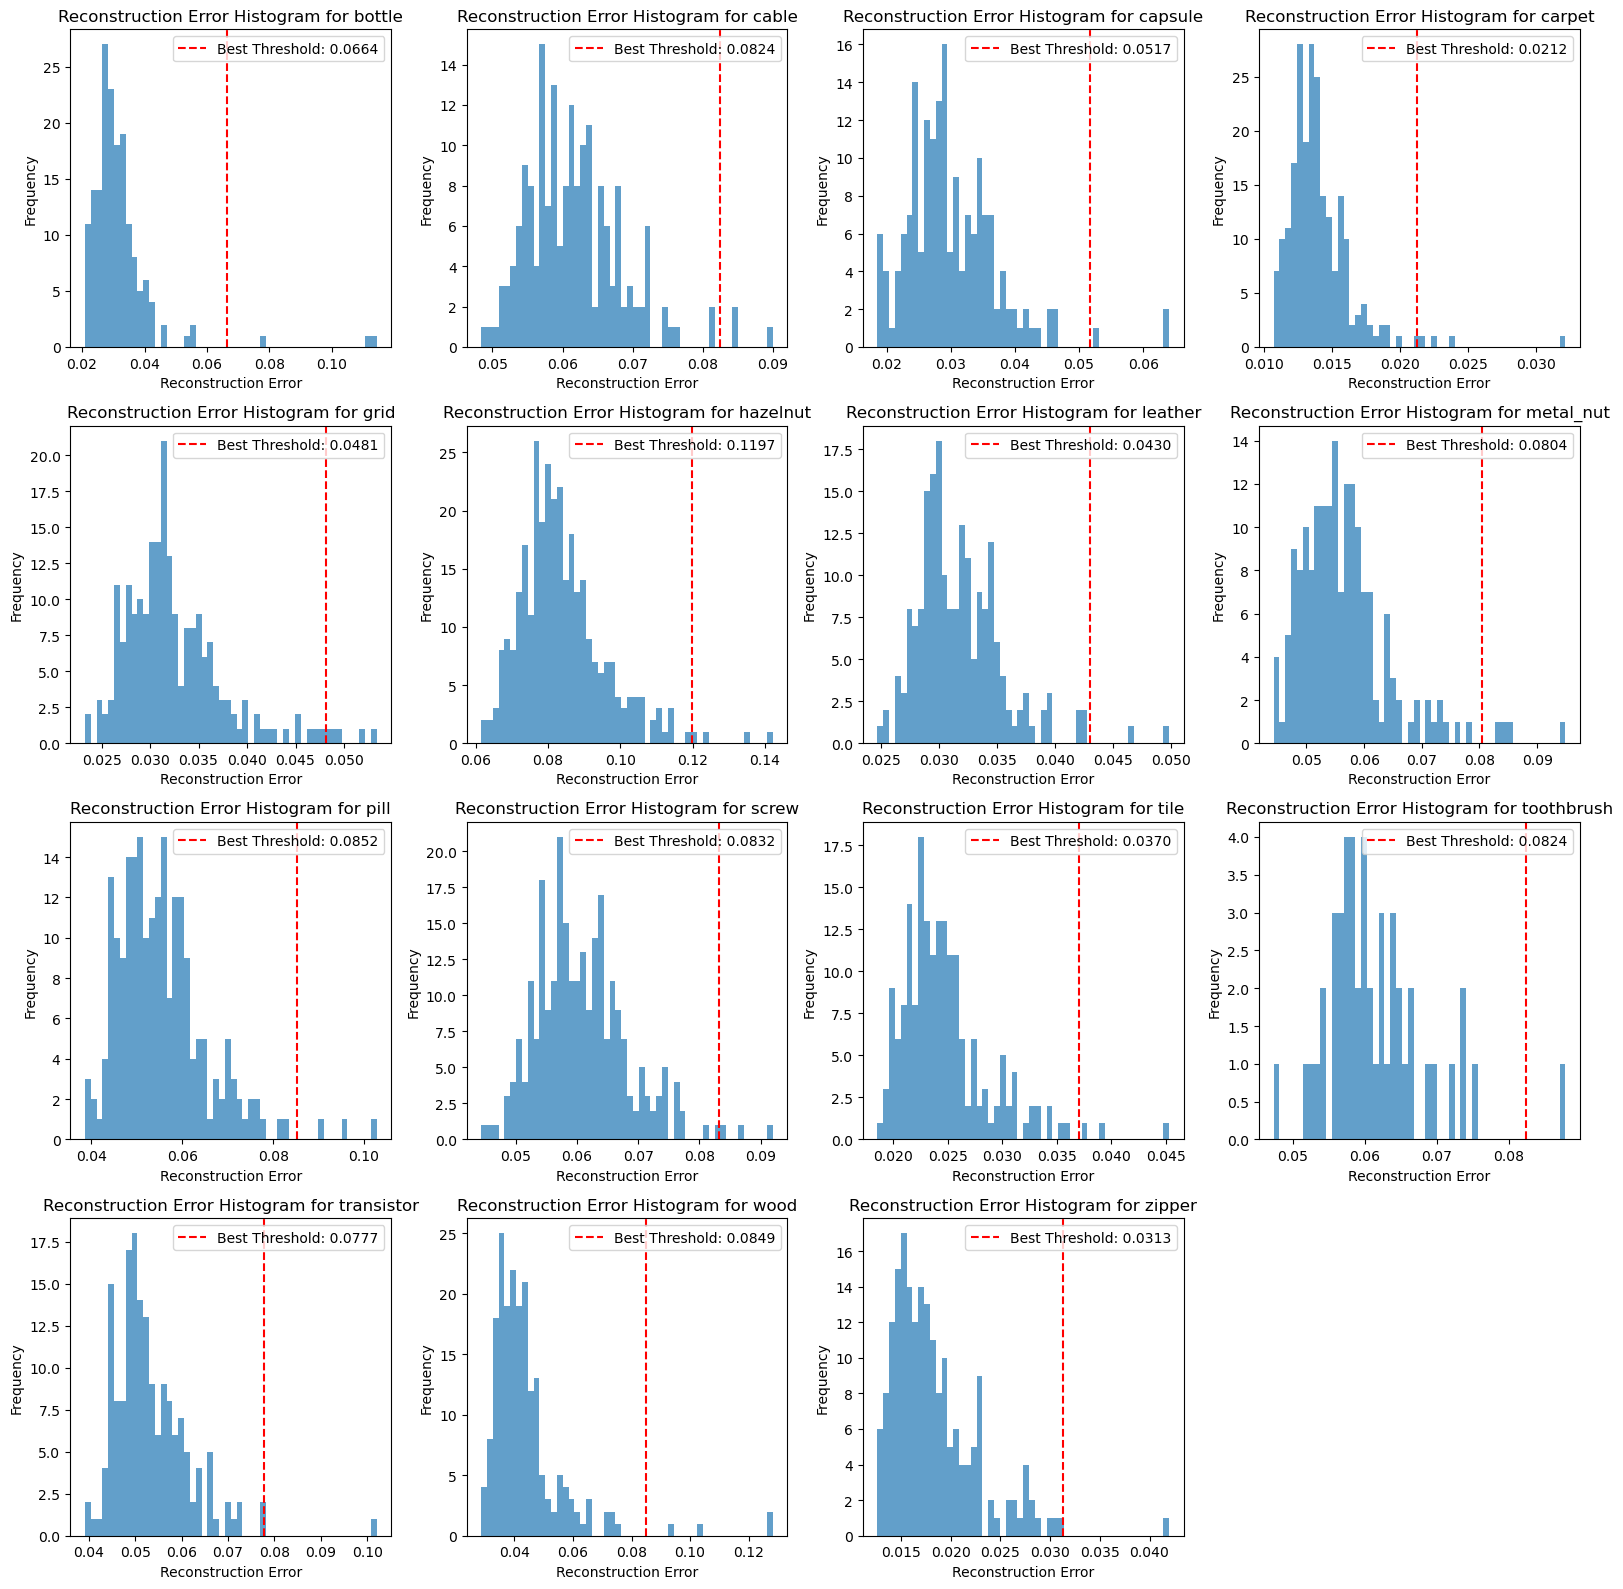

In [22]:
import math

best_thresholds = {}

num_categories = len(RECON_ERROR)
cols = 4
rows = math.ceil(num_categories / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for idx, (category, errors) in enumerate(RECON_ERROR.items()):
    threshold = np.mean(errors) + 3 * np.std(errors)
    best_thresholds[category] = threshold
    
    axes[idx].hist(errors, bins=50, alpha=0.7)
    axes[idx].axvline(x=threshold, color='r', linestyle='--', label=f'Best Threshold: {threshold:.4f}')
    axes[idx].set_title(f'Reconstruction Error Histogram for {category}')
    axes[idx].set_xlabel('Reconstruction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Hide any unused subplots
for ax in axes[num_categories:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## *7. Test Images*

### **7.1. Evaluation on test images for fault detection using reconstruction error**

This code evaluates the model on the test dataset, calculates reconstruction errors, and generates predictions for fault detection using the best thresholds calculated earlier.

####  **Steps**:
  1. **Initialize dictionaries for true labels, predictions, and scores**:
       - `y_true`: Stores the true labels (fault/no-fault) for each category.
       - `y_pred`: Stores the predicted labels (fault/no-fault) for each category.
       - `y_score`: Stores the reconstruction scores for each test image.
  2. **Set models to evaluation mode**:
       - `model.eval()` and `backbone.eval()` set both the model and backbone to evaluation mode to disable layers like dropout.
  3. **Iterate through test images**:
       - For each category, iterate through its test paths (`test_paths`).
       - For each image in `test_paths`, perform the following:
         - **Load the image**: Open the image from the path, convert it to RGB if necessary, and apply the transformation (`transform`).
         - **Extract features and reconstruct image**: Pass the image through the `backbone` to extract features, then pass those features through the `loaded_models[category]` to get the reconstructed image.
         - **Calculate reconstruction error**: Compute the segmentation map by calculating the squared difference between the original features and the reconstructed image. This helps in detecting anomalies in the reconstruction.
         - **Compute anomaly score**: Use `decision_function(segm_map)` to get an anomaly score for each feature map.
         - **Make prediction**: Compare the anomaly score with the best threshold for the category to determine whether the prediction is a fault (1) or good (0).
         - **Assign ground truth label**: If the fault type (from the directory structure) is 'good', assign a label of 0 (no fault), otherwise assign a label of 1 (fault).
         - Append the true label (`y_true_image`), predicted label (`y_pred_image`), and the anomaly score (`y_score_image`) to the corresponding lists in `y_true`, `y_pred`, and `y_score` dictionaries.
  4. **Convert lists to numpy arrays**: Convert the lists in `y_true`, `y_pred`, and `y_score` into numpy arrays for further analysis (e.g., evaluation metrics).

####  **Output**:
  - `y_true`: Dictionary containing the true labels (0 for good, 1 for fault) for each category in the test set.
  - `y_pred`: Dictionary containing the predicted labels (0 or 1) for each category.
  - `y_score`: Dictionary containing the reconstruction anomaly scores for each test image.

####  **Usage**:
This code prepares the necessary data for performance evaluation by comparing true labels (`y_true`) with predicted labels (`y_pred`), and using reconstruction scores (`y_score`) for anomaly detection.


In [23]:
y_true = {category: [] for category in categories[min_categories:max_categories]}
y_pred = {category: [] for category in categories[min_categories:max_categories]}
y_score = {category: [] for category in categories[min_categories:max_categories]}

model.eval()
backbone.eval()

with torch.no_grad():
    for category in categories[min_categories:max_categories]:
        test_paths = test_datasets_dict[category]
        
        for path in test_paths:
            # Convert string path to Path object
            path_obj = Path(path)
            # Get the parent folder name which indicates the fault type
            fault_type = path_obj.parent.name
            
            # Ensure the image is in RGB format
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            test_image = transform(img).cuda().unsqueeze(0)
            features = backbone(test_image)
            recon_image = loaded_models[category](features)
            
            segm_map = ((features - recon_image)**2).mean(axis=(1))[:,3:-3,3:-3]
            y_score_image = decision_function(segm_map=segm_map)
            y_pred_image = 1 * (y_score_image >= best_thresholds[category])
            
            y_true_image = 0 if fault_type == 'good' else 1
            
            y_true[category].append(y_true_image)
            y_pred[category].append(y_pred_image.cpu().numpy())
            y_score[category].append(y_score_image.cpu().numpy())
    
    # Convert lists to numpy arrays
    y_true = {category: np.array(values) for category, values in y_true.items()}
    y_pred = {category: np.array(values) for category, values in y_pred.items()}
    y_score = {category: np.array(values) for category, values in y_score.items()}

### **7.2. Visualization of Anomaly Scores for Each Category**

This code plots the histograms of the reconstruction scores (`y_score`) for each category, marking the best threshold for anomaly detection with a vertical red line. It helps visualize the distribution of the reconstruction scores and the threshold used for classification.

#### **Steps**:
  1. **Set up subplot grid**:
       - Calculate the number of categories to display (`num_categories`).
       - Define the number of columns (`cols`) and rows (`rows`) for the subplots. The number of rows is calculated based on the total number of categories, ensuring each category is shown in a separate subplot.
       - Create a figure with subplots (`fig, axes`) using `plt.subplots`, ensuring the layout fits the number of categories.
  2. **Plot histograms**:
       - Iterate over each category in the selected range (`categories[min_categories:max_categories]`).
       - For each category:
         - Plot a histogram of the reconstruction scores (`y_score[category]`), with 50 bins and alpha transparency for visibility.
         - Draw a vertical red line at the `best_thresholds[category]` value, which represents the threshold for distinguishing normal and faulty categories.
         - Set the title, x-label, and y-label for each subplot.
  3. **Hide unused subplots**:
       - If there are more subplots than categories, hide the extra subplots to keep the display clean.
  4. **Display the plot**:
       - Call `plt.tight_layout()` to optimize the layout and avoid overlap between subplots.
       - Show the plot with `plt.show()`.

#### **Output**:
  - A grid of histograms where each subplot corresponds to one category, showing the distribution of reconstruction scores (`y_score`) and the best threshold used for anomaly detection.
#### **Usage**:
  - This code helps visualize the reconstruction error distribution across different categories, which can be useful for understanding how well the threshold for anomaly detection separates normal and faulty samples.


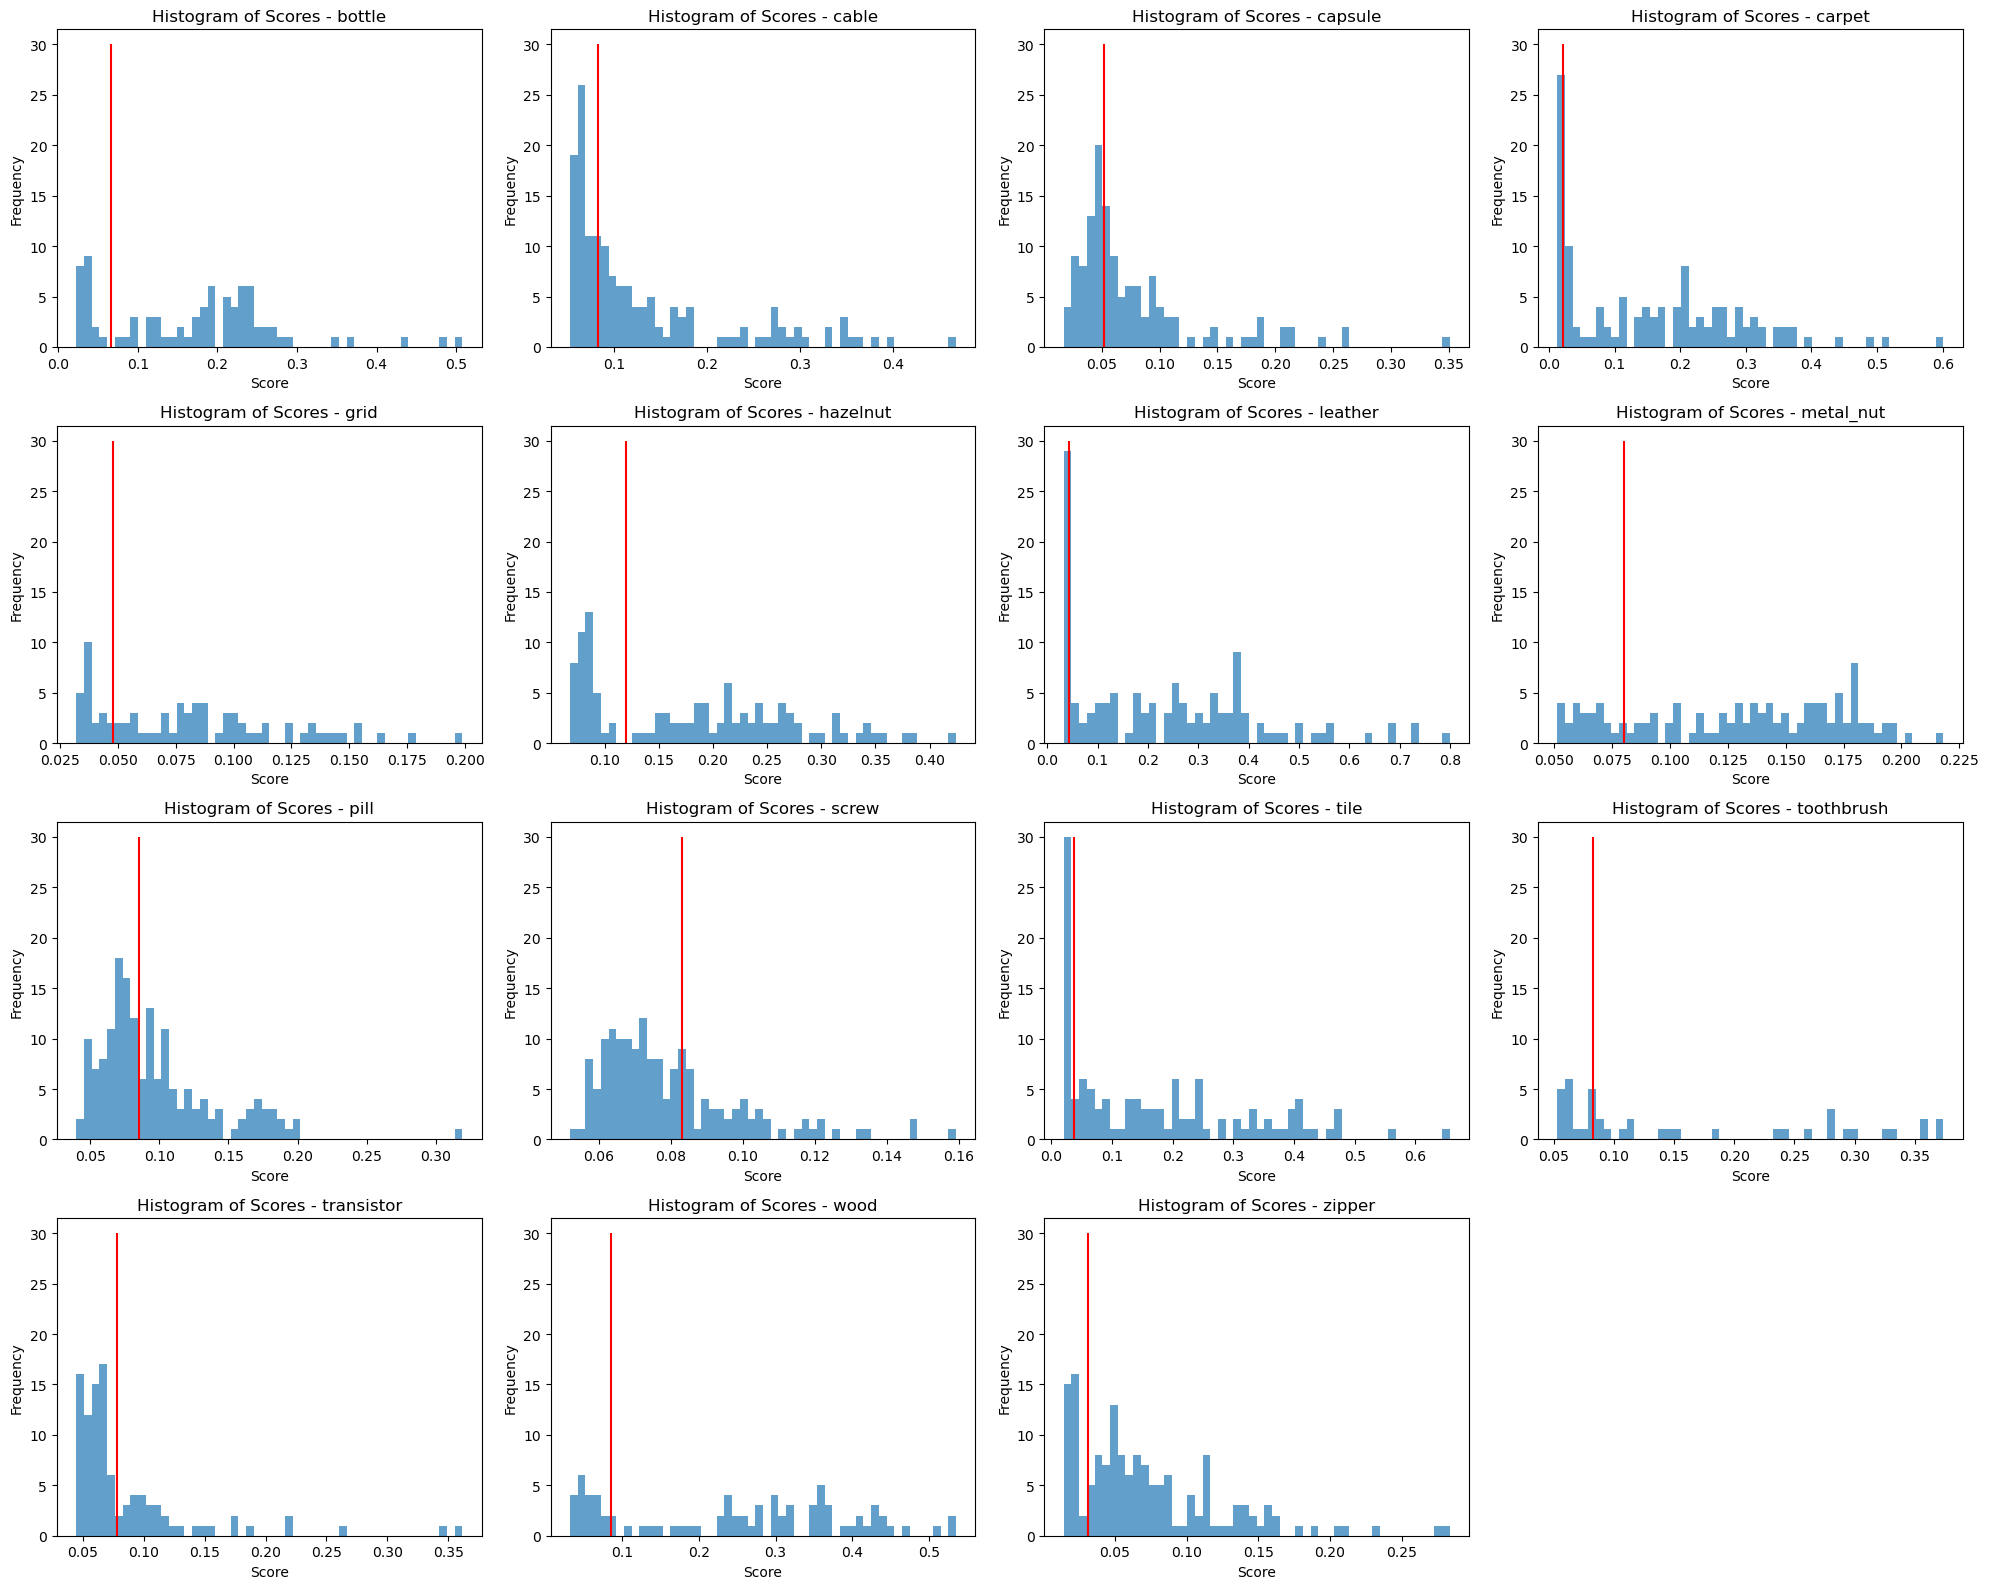

In [24]:
import math

num_categories = len(categories[min_categories:max_categories])
cols = 4
rows = math.ceil(num_categories / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for idx, category in enumerate(categories[min_categories:max_categories]):
    axes[idx].hist(y_score[category], bins=50, alpha=0.7)
    axes[idx].vlines(x=best_thresholds[category], ymin=0, ymax=30, color='r')
    axes[idx].set_title(f'Histogram of Scores - {category}')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Frequency')

# Hide any unused subplots
for ax in axes[num_categories:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### **7.3.Code Block**: Plotting ROC Curves and Confusion Matrices**

This code visualizes the performance of the anomaly detection models using ROC curves and confusion matrices. It also calculates the optimal thresholds using F1 scores for each category, then plots both the ROC curves and confusion matrices for better evaluation of model performance.

#### **Steps**:
  1. **Plot ROC Curves**:
       - **Subplots Setup**:
         - Calculate the number of rows and columns for subplots based on the total number of categories.
         - Create a subplot grid (`fig_roc, axes_roc`) to display ROC curves for each category.
       - **For each category**:
         - Calculate the **AUC-ROC score** (`auc_roc_score`) using `roc_auc_score`.
         - Calculate the **False Positive Rate (FPR)** and **True Positive Rate (TPR)** using `roc_curve`.
         - Plot the ROC curve (`fpr` vs. `tpr`) and display the AUC score in the legend.
         - Add a diagonal line representing a random classifier (i.e., a 50% chance).
         - Set the x-axis and y-axis labels as "False Positive Rate" and "True Positive Rate", respectively.
         - Add a title displaying the category and the AUC score.
       - **Remove empty subplots**: If there are unused subplots (e.g., if the number of categories is not a perfect multiple of rows * columns), remove them from the figure.
       - Call `plt.tight_layout()` and `plt.show()` to ensure proper layout and display of the plots.

  2. **Plot Confusion Matrices**:
       - **Subplots Setup**:
         - Create another subplot grid (`fig_cm, axes_cm`) for the confusion matrices.
       - **For each category**:
         - Compute the **F1 scores** for each threshold using `f1_score` by iterating over the thresholds from the ROC curve.
         - Identify the threshold that gives the highest **F1 score** (`best_threshold`).
         - Compute the confusion matrix using `confusion_matrix` with the optimal threshold (`best_threshold`).
         - Display the confusion matrix using `ConfusionMatrixDisplay`, labeling the axes as "OK" and "NOK" for normal and anomalous categories.
         - Add a title showing the category, best threshold, and best F1 score.
       - **Remove empty subplots**: Similarly, remove unused subplots if there are more than necessary.
       - Call `plt.tight_layout()` and `plt.show()` for proper display.

#### **Output**:
  - Two sets of plots:
      - ROC curves for each category, displaying the trade-off between true positive rate and false positive rate, along with the AUC score.
      - Confusion matrices for each category, with the optimal threshold and F1 score shown in the titles.
      
#### **Usage**:
  - ROC curves provide insight into the model's performance at various thresholds, allowing for a clear understanding of how well the model distinguishes between the classes.
  - Confusion matrices show how well the model classifies the categories into normal (OK) and faulty (NOK) classes, with optimal threshold determination based on F1 scores.


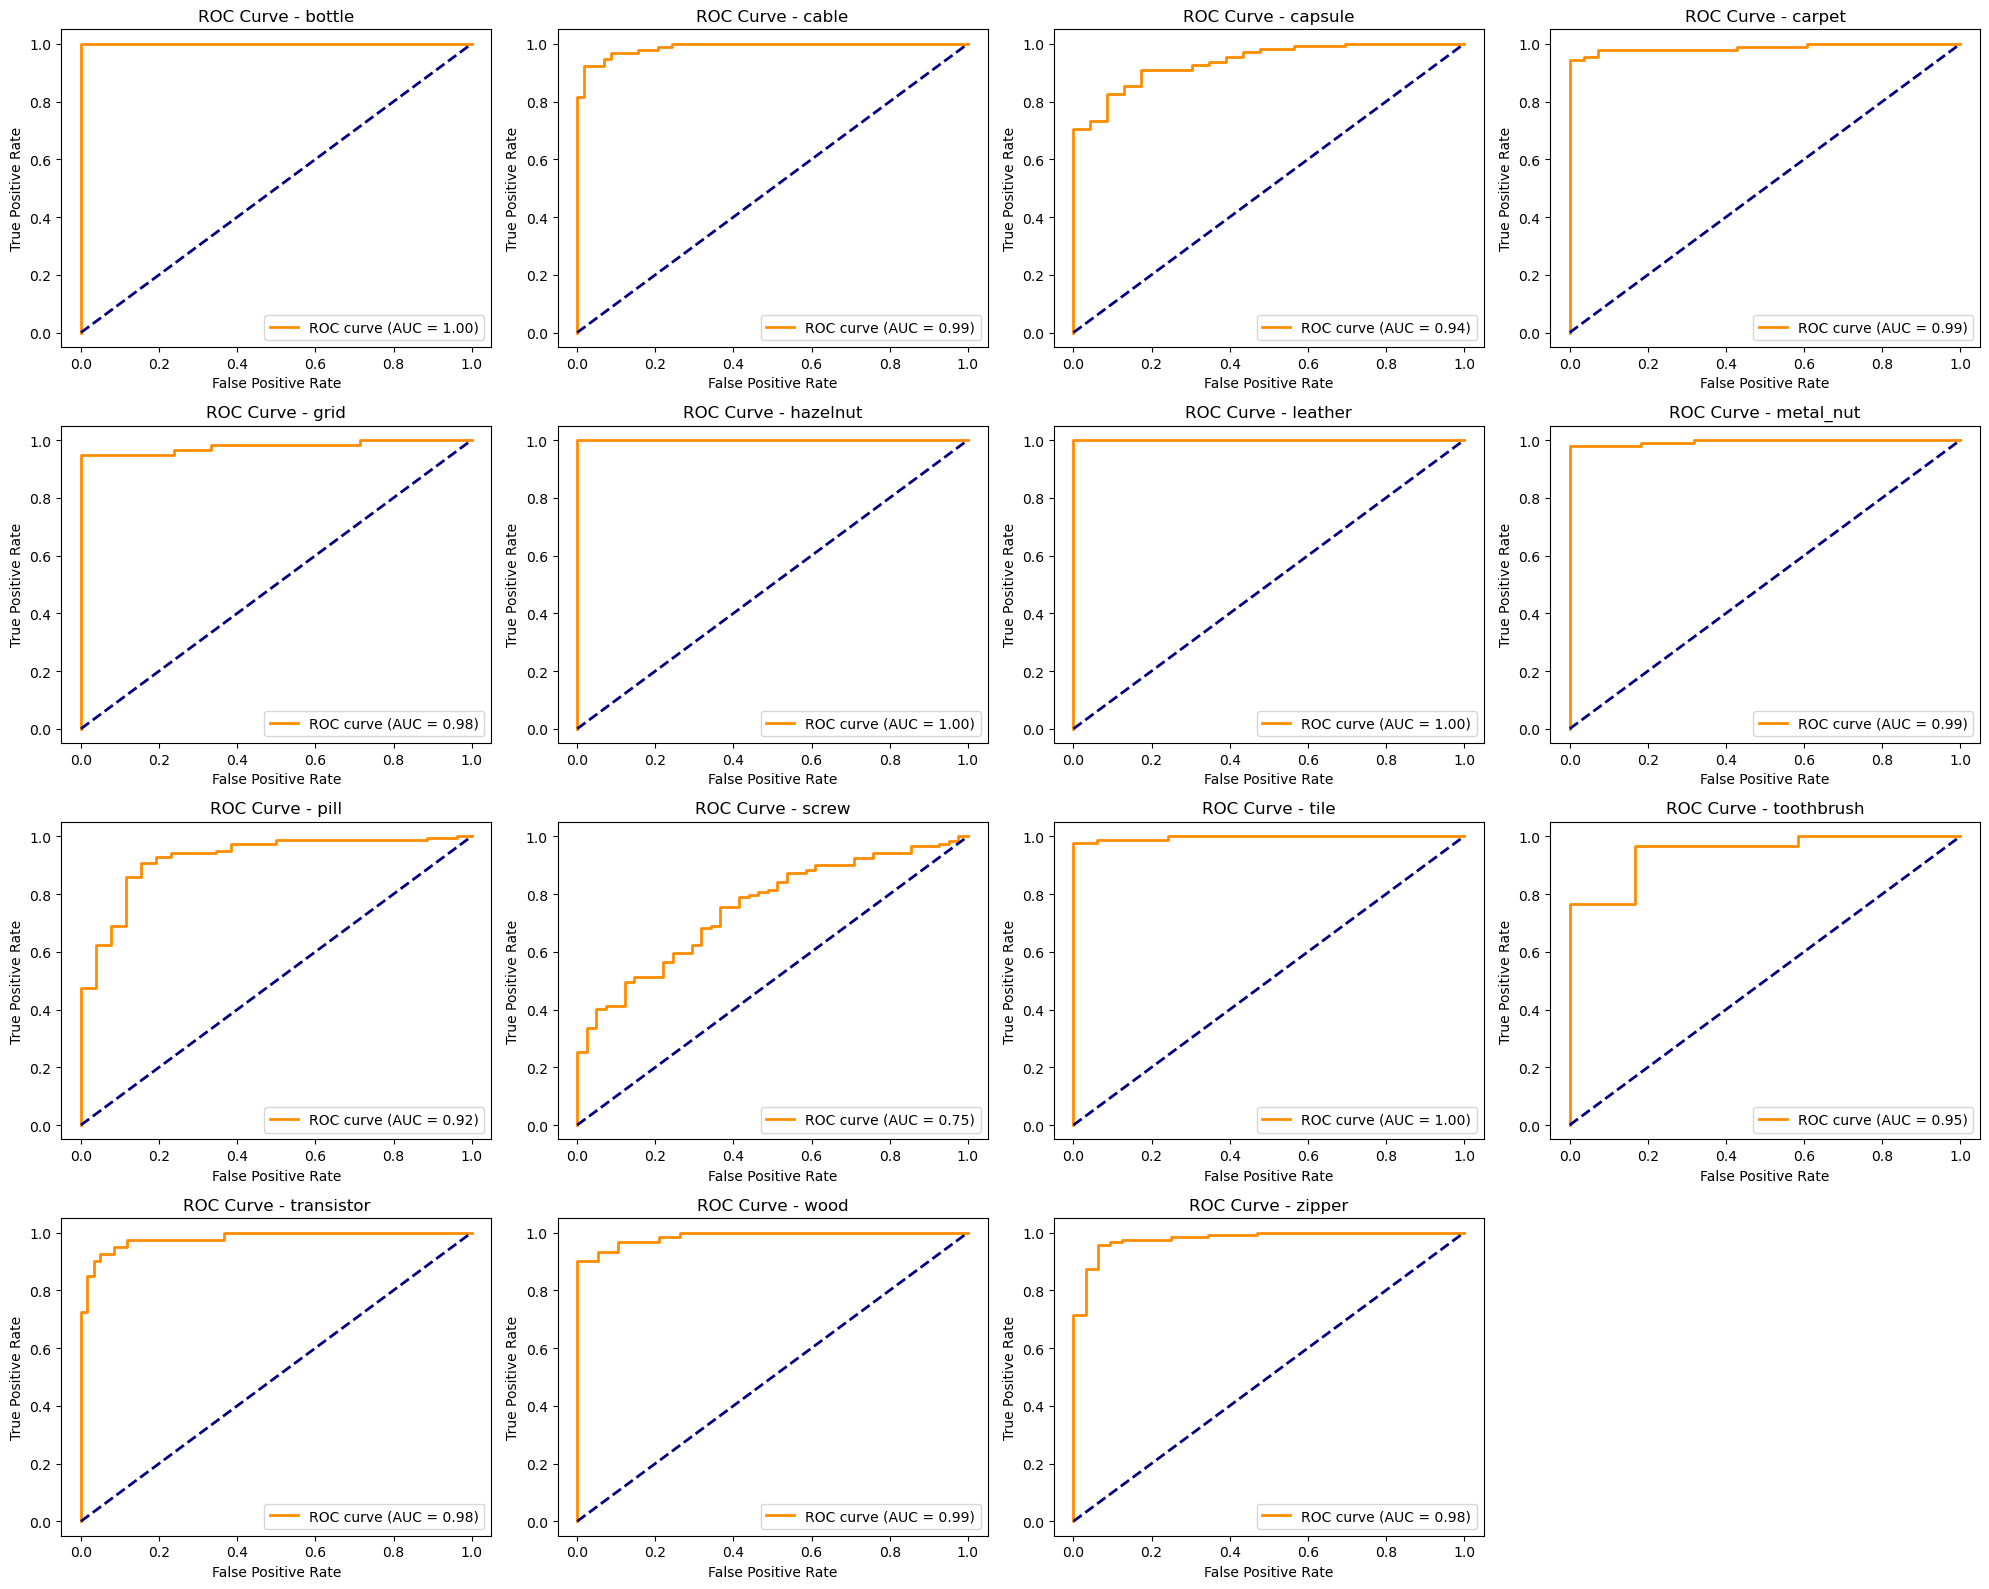

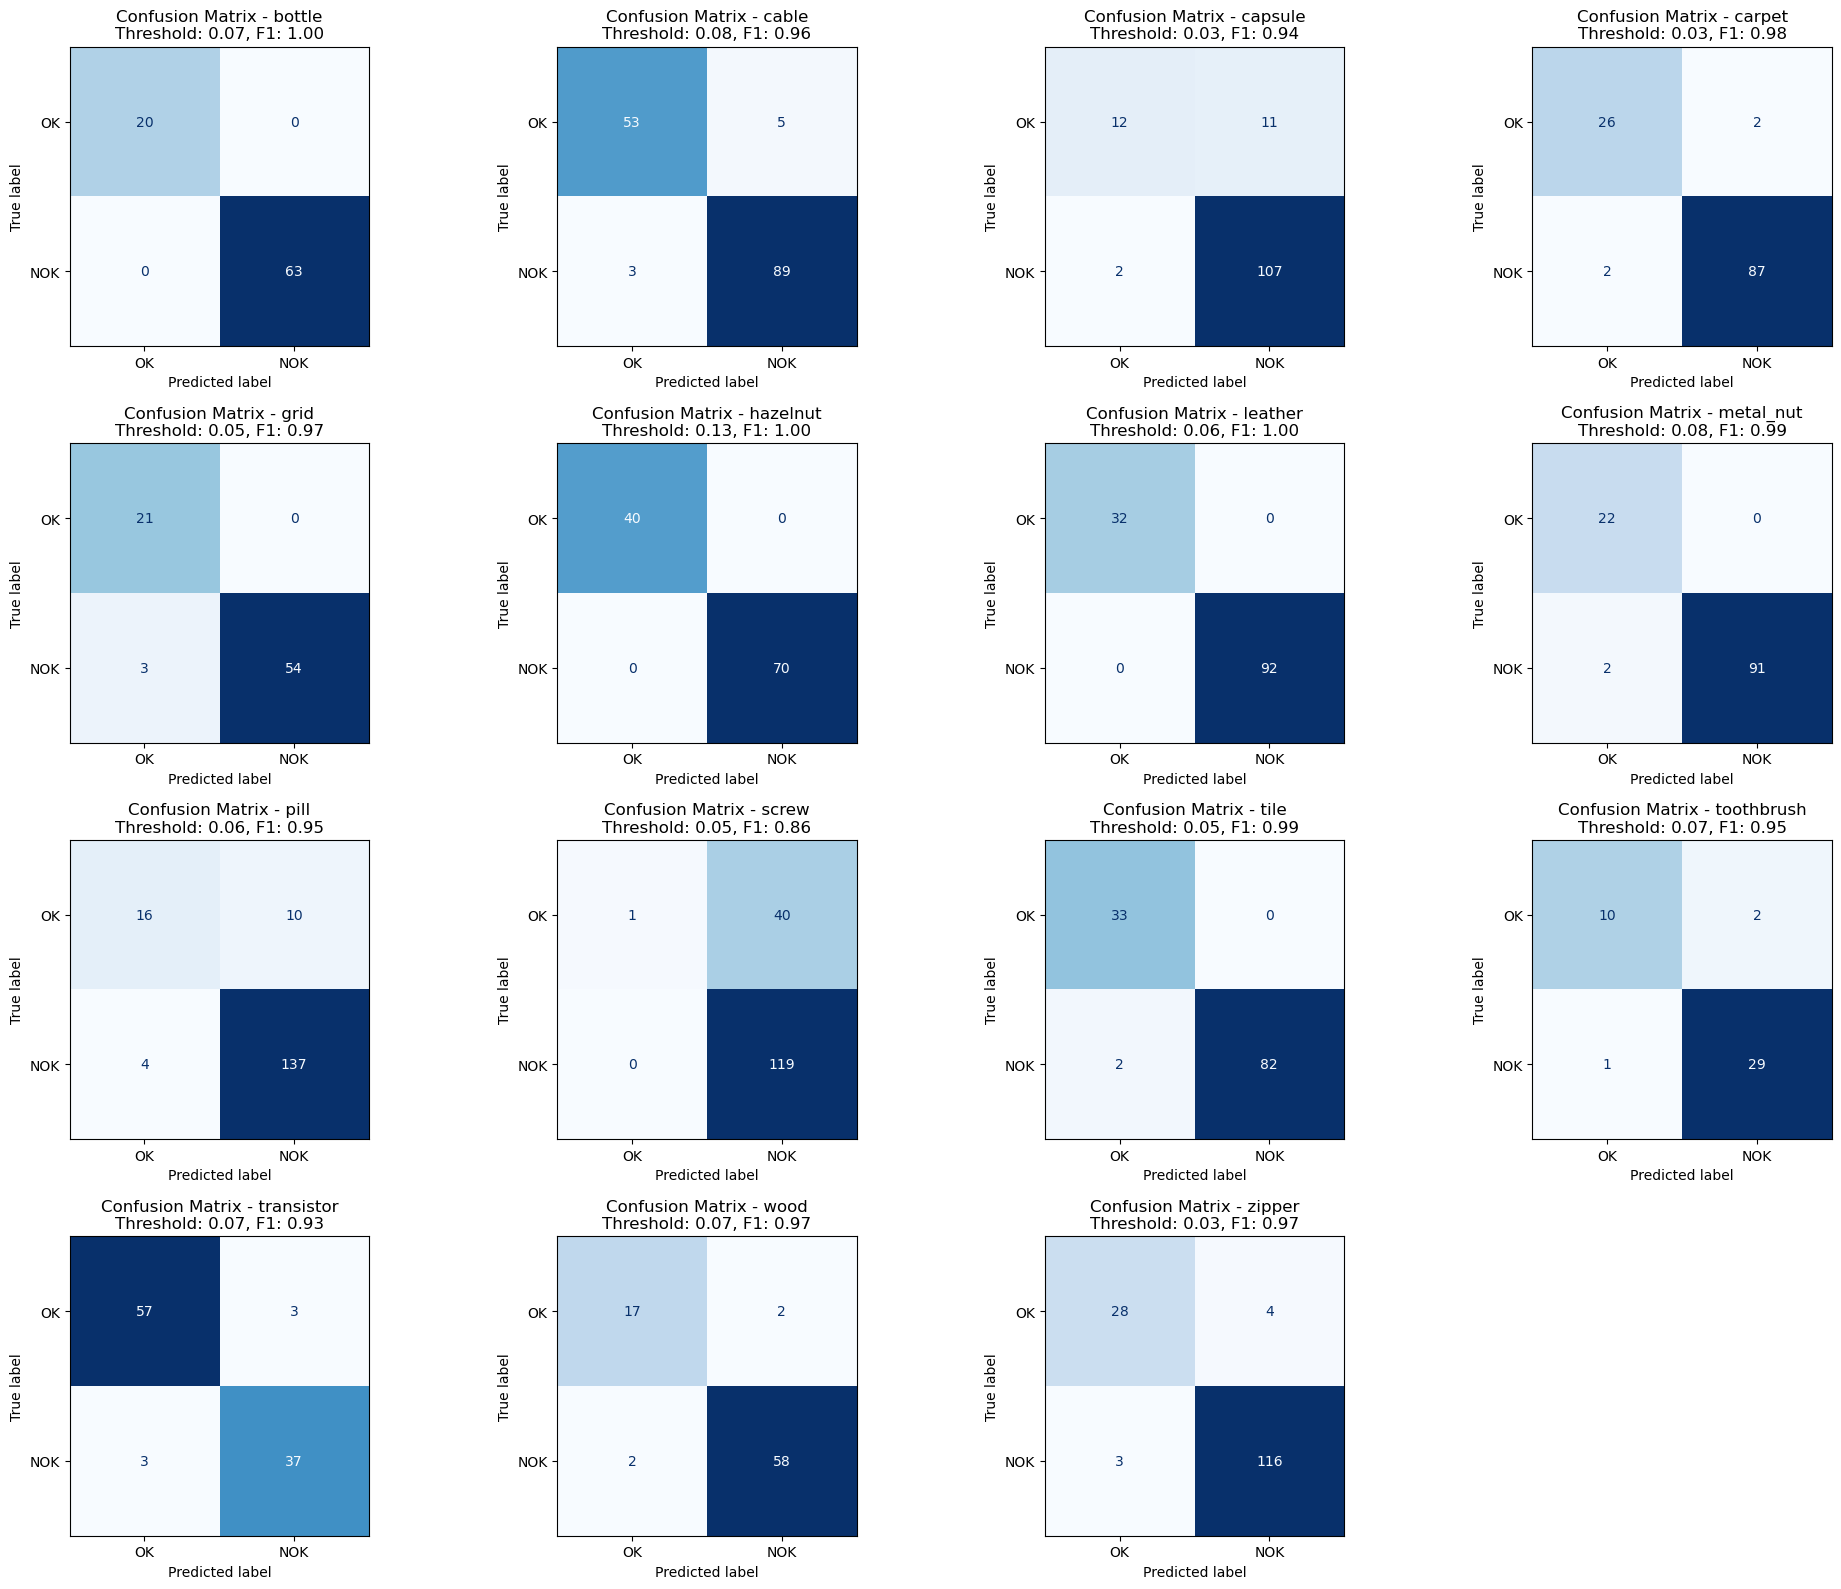

In [49]:
import math
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

num_categories = len(categories[min_categories:max_categories])
cols = 4
rows = math.ceil(num_categories / cols)

# Plot ROC Curves
fig_roc, axes_roc = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes_roc = axes_roc.flatten()

for idx, category in enumerate(categories[min_categories:max_categories]):
	auc_roc_score = roc_auc_score(y_true[category], y_score[category])
	fpr, tpr, _ = roc_curve(y_true[category], y_score[category])
	
	axes_roc[idx].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc_score:.2f})')
	axes_roc[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	axes_roc[idx].set_xlabel('False Positive Rate')
	axes_roc[idx].set_ylabel('True Positive Rate')
	axes_roc[idx].set_title(f'ROC Curve - {category}')
	axes_roc[idx].legend(loc="lower right")

# Remove empty subplots
for idx in range(num_categories, rows * cols):
	fig_roc.delaxes(axes_roc[idx])

plt.tight_layout()
plt.show()

# Plot Confusion Matrices
fig_cm, axes_cm = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes_cm = axes_cm.flatten()

for idx, category in enumerate(categories[min_categories:max_categories]):
	_, _, thresholds = roc_curve(y_true[category], y_score[category])
	f1_scores = [f1_score(y_true[category], y_score[category] >= threshold) for threshold in thresholds]
	best_idx = np.argmax(f1_scores)
	best_threshold = thresholds[best_idx]
	best_f1 = f1_scores[best_idx]
	
	cm = confusion_matrix(y_true[category], (y_score[category] >= best_threshold).astype(int))
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
	disp.plot(ax=axes_cm[idx], cmap='Blues', colorbar=False)
	
	axes_cm[idx].set_title(f'Confusion Matrix - {category}\nThreshold: {best_threshold:.2f}, F1: {best_f1:.2f}')

# Remove empty subplots
for idx in range(num_categories, rows * cols):
	fig_cm.delaxes(axes_cm[idx])

plt.tight_layout()
plt.show()


## *8. Visualizing Anomaly Detection Results on Test Images*

This code visualizes the results of the anomaly detection model on a random sample of images from the test set. It displays the input image, the generated anomaly heatmap, a segmented version of the heatmap focusing on high anomaly scores, and the ground truth (if available) for comparison.

####  **Steps**:
#####    1. **Prepare Test Data**:
   - For each category (from `min_categories` to `max_categories`), the code accesses the test set directory.
   - Selects **non-good images** (`NOK`) and randomly samples one of these images.
       
#####    2. **Anomaly Detection**:
   - For the sampled image:
   - Converts it to RGB if needed.
   - Applies the `transform` to the image and moves it to GPU (`cuda()`).
   - Passes the image through the `backbone` and the `loaded_model` for feature extraction and reconstruction.
   - Computes the **segmentation map** by calculating the squared difference between the features and the reconstructed output.
   - Uses the **decision function** to compute an anomaly score (`y_score_image`), comparing it to the pre-determined threshold to make a classification prediction (`y_pred_image`).
       
#####    3. **Visualization**:
   - A 4-part figure is created:
   - **Part 1**: The original test image.
   - **Part 2**: The **anomaly heatmap**, which shows the regions with high reconstruction errors. The heatmap is resized to 224x224 pixels and displayed using a **jet colormap**.
   - **Part 3**: The **segmentation map**, where high anomaly areas (red/orange/yellow) are highlighted using a binary mask (`highlight_mask`).
   - **Part 4**: The **ground truth** mask (if available), which is loaded from a corresponding file. If the ground truth image does not exist, it displays a message saying "No Ground Truth".
   - All plots are arranged neatly with `plt.tight_layout()` and shown using `plt.show()`.

####  **Output**:
   - The figure displays:
    - The original image from the test set.
    - The generated anomaly heatmap, showing areas with high anomaly scores.
    - The segmented version of the heatmap, focusing on the regions with the highest anomaly scores.
    - The ground truth mask (if available) for comparison.

####  **Usage**:
This visualization helps to interpret the model's performance by clearly showing which regions of the image are identified as anomalies. It allows you to compare the model's output against the ground truth, if available.


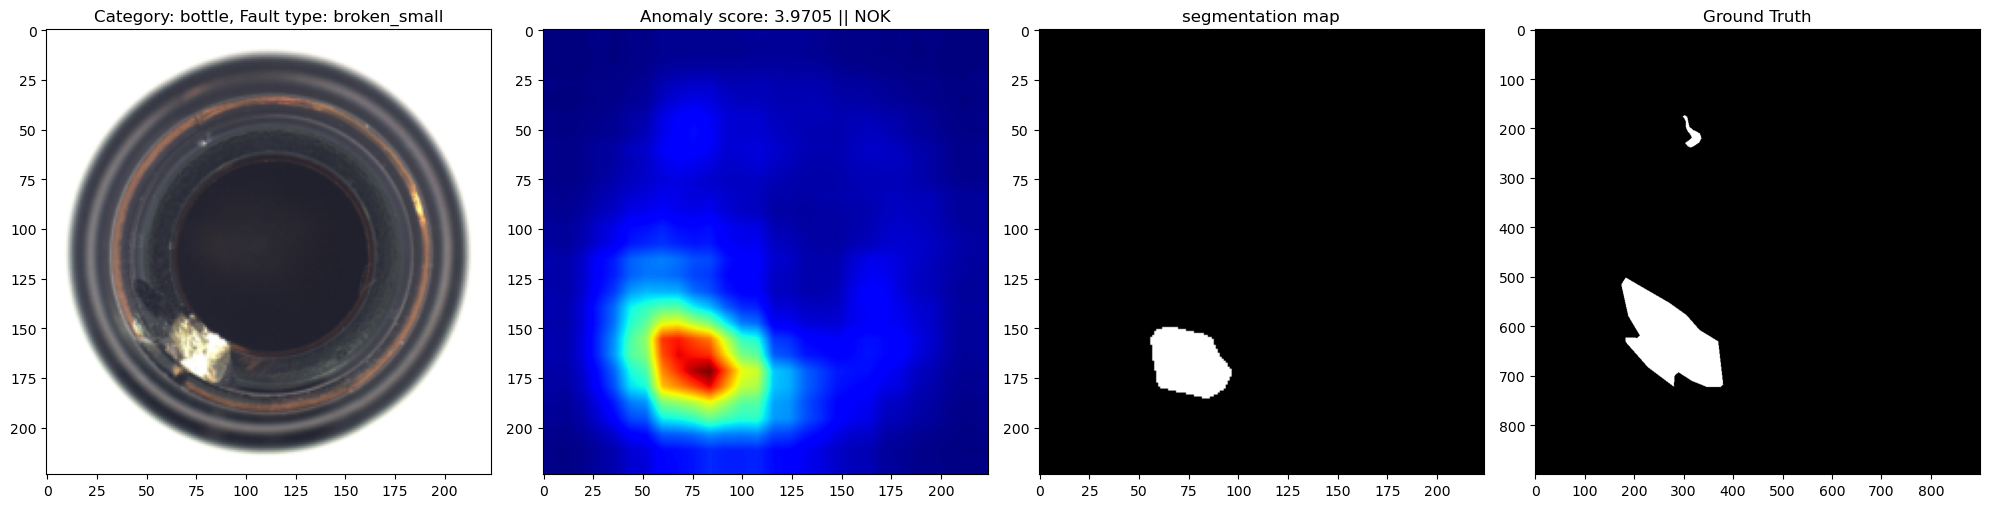

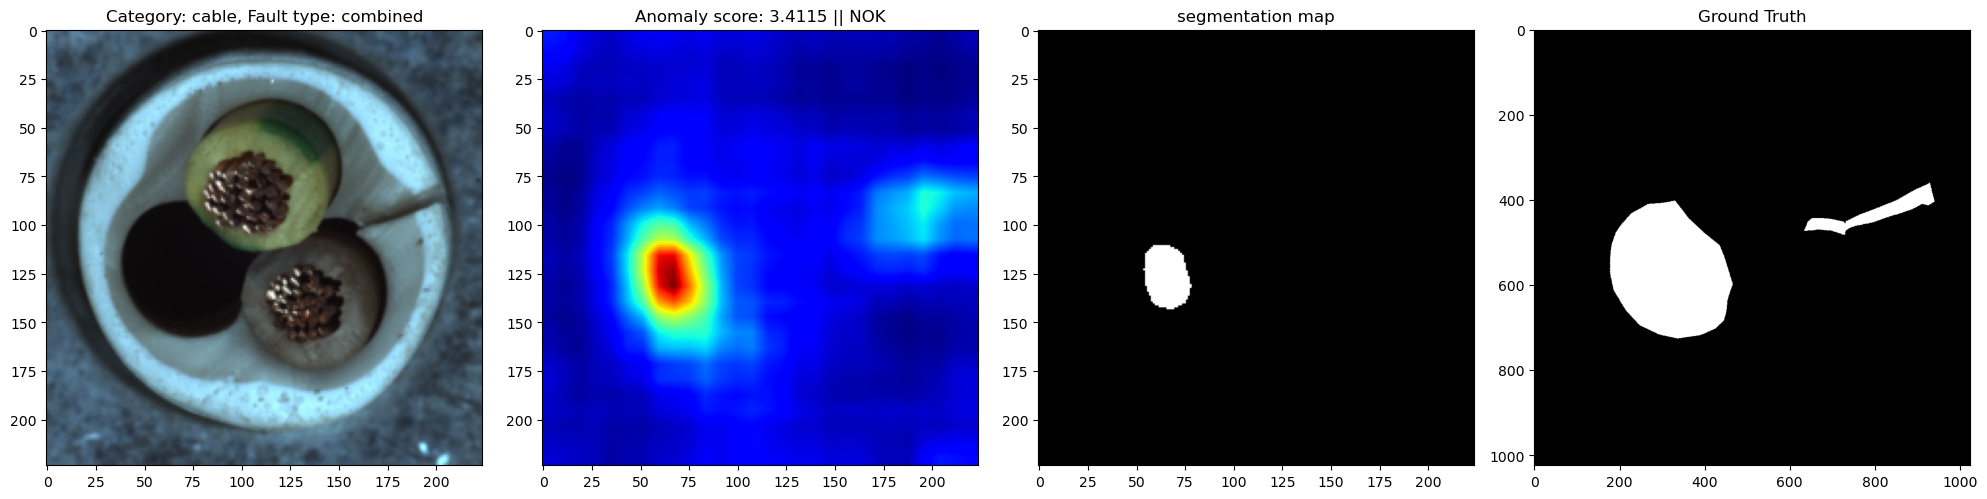

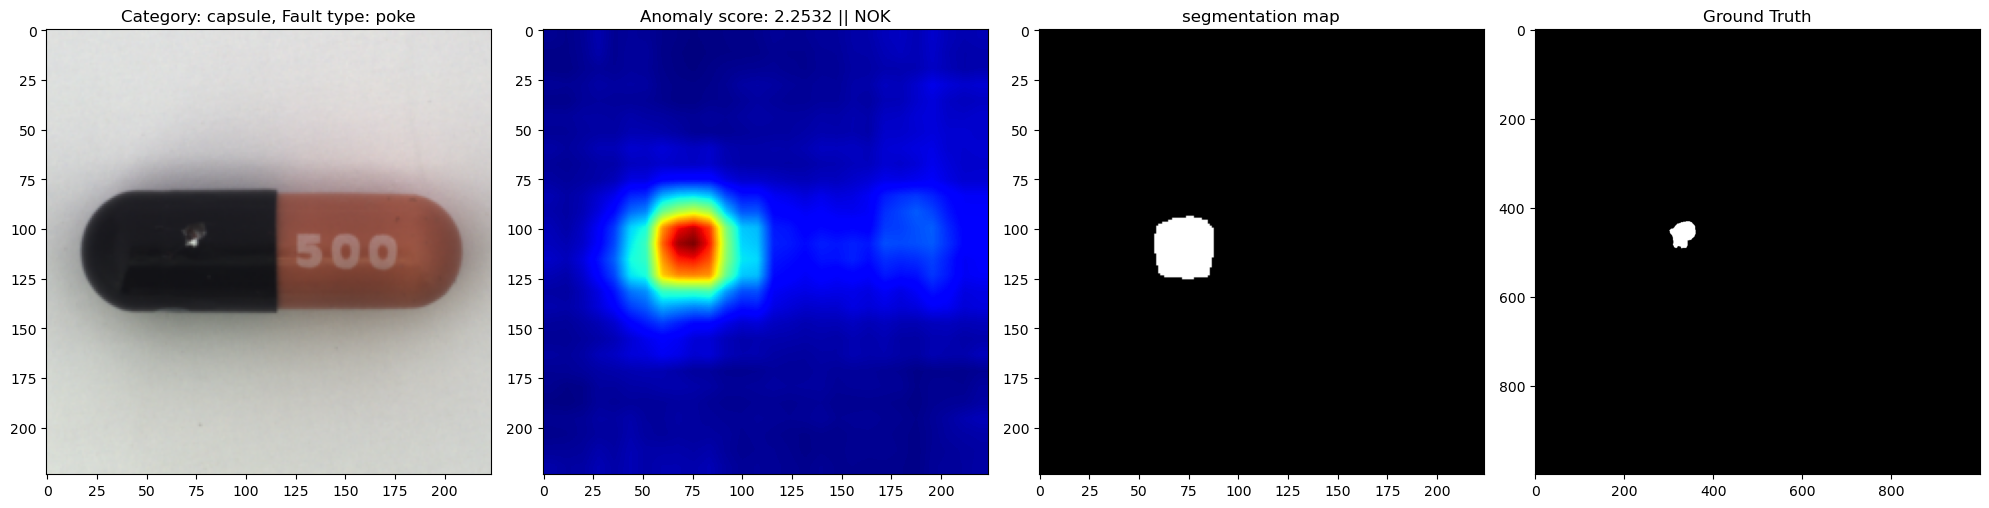

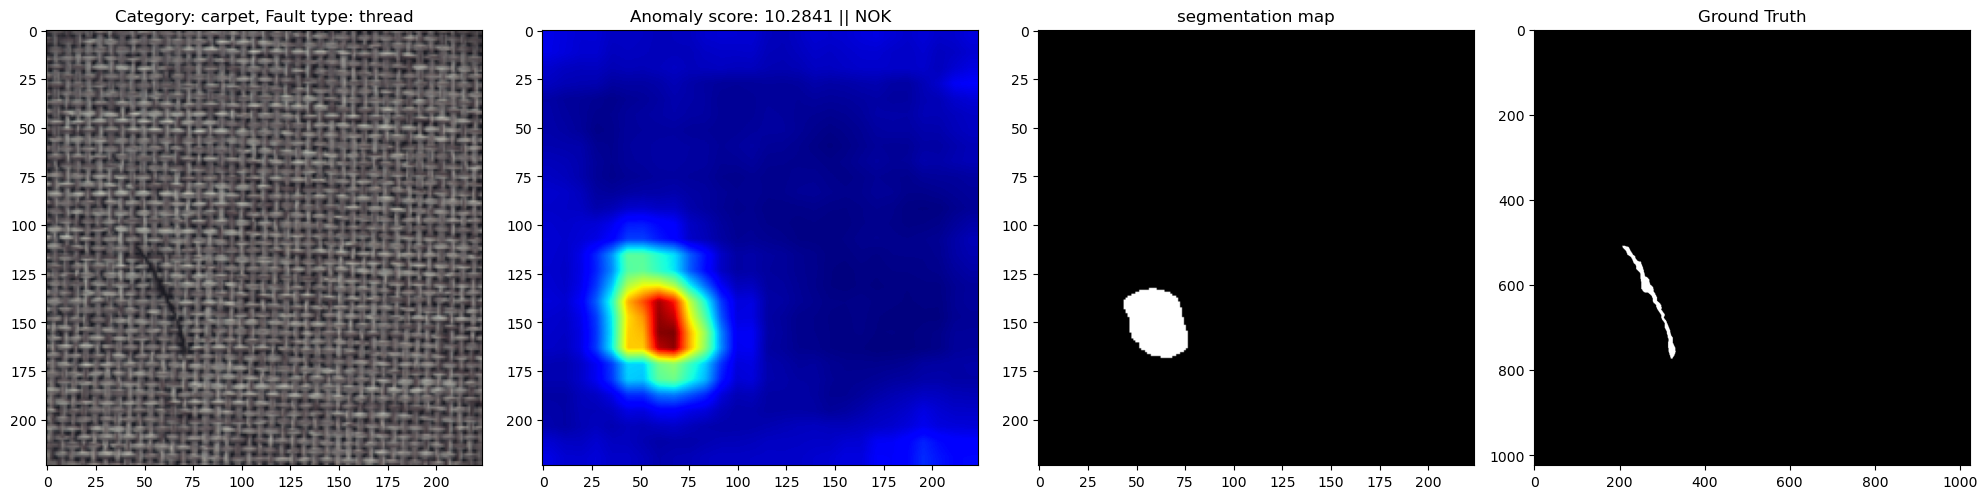

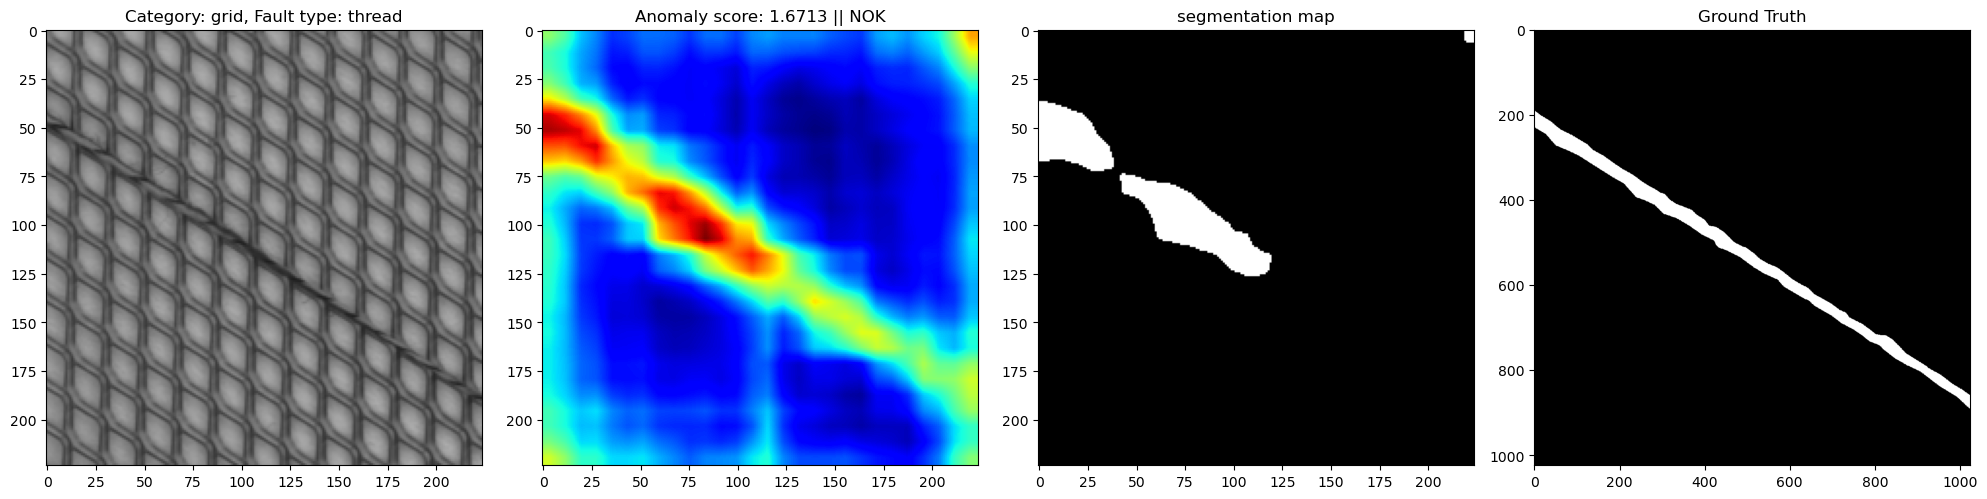

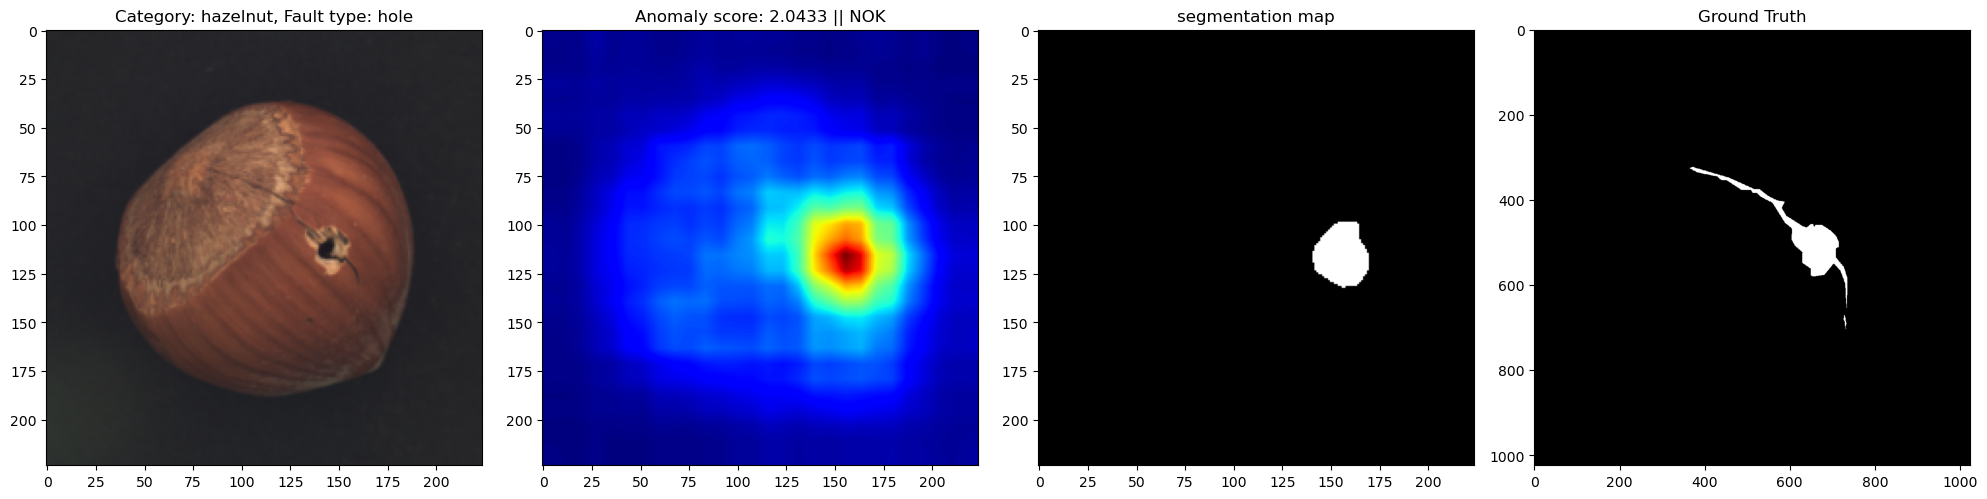

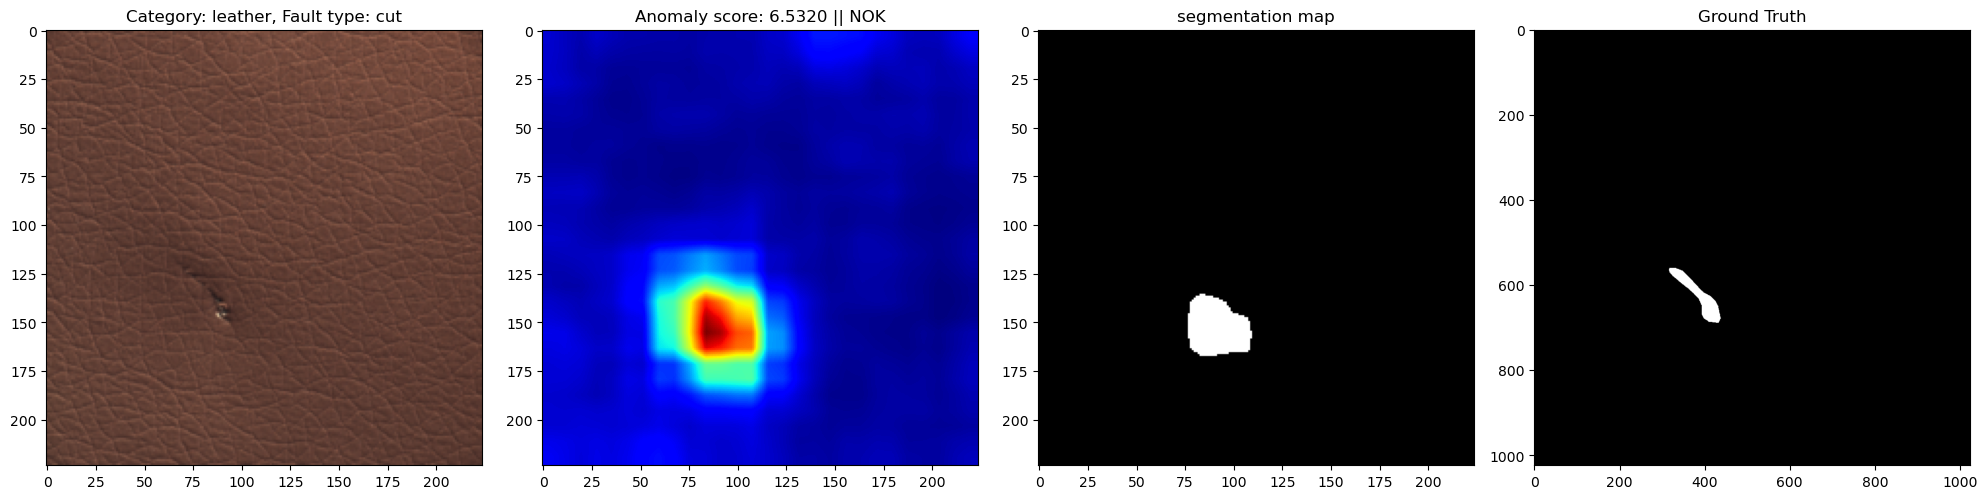

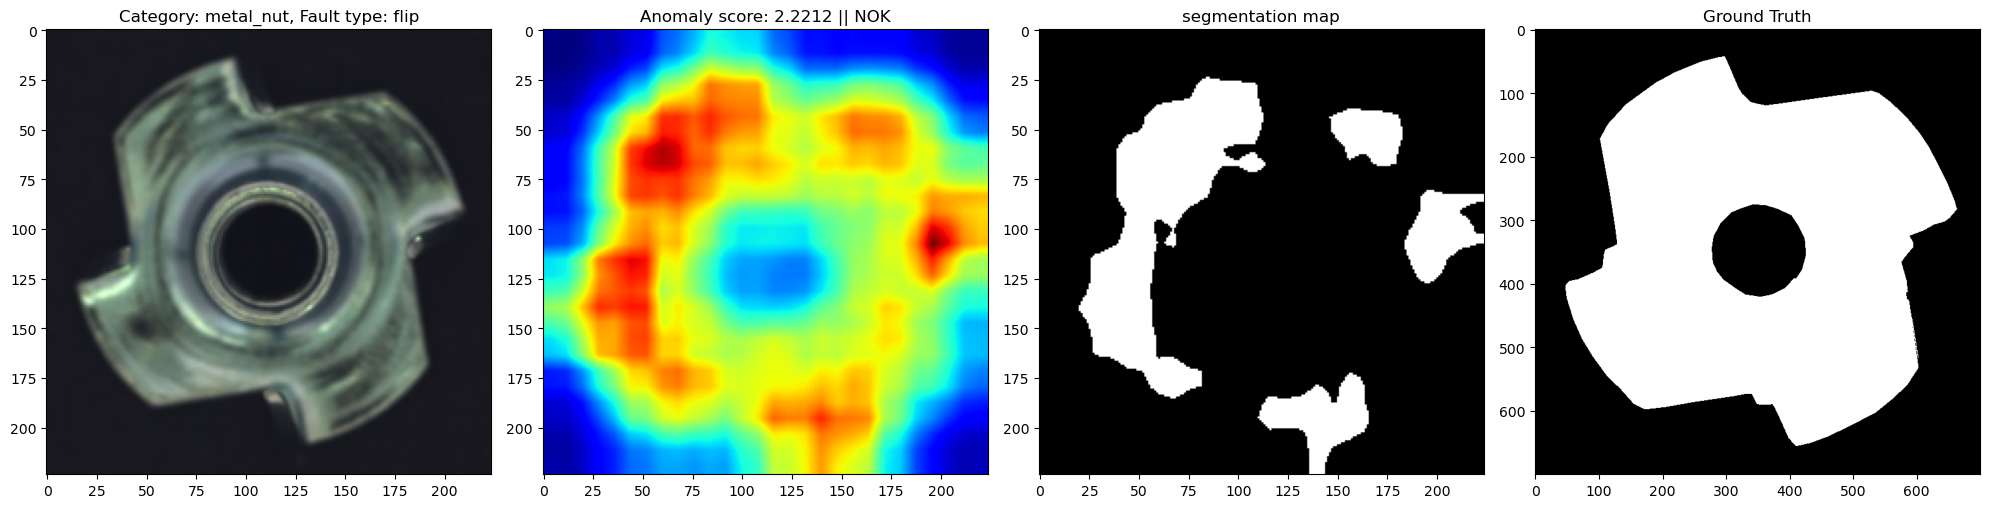

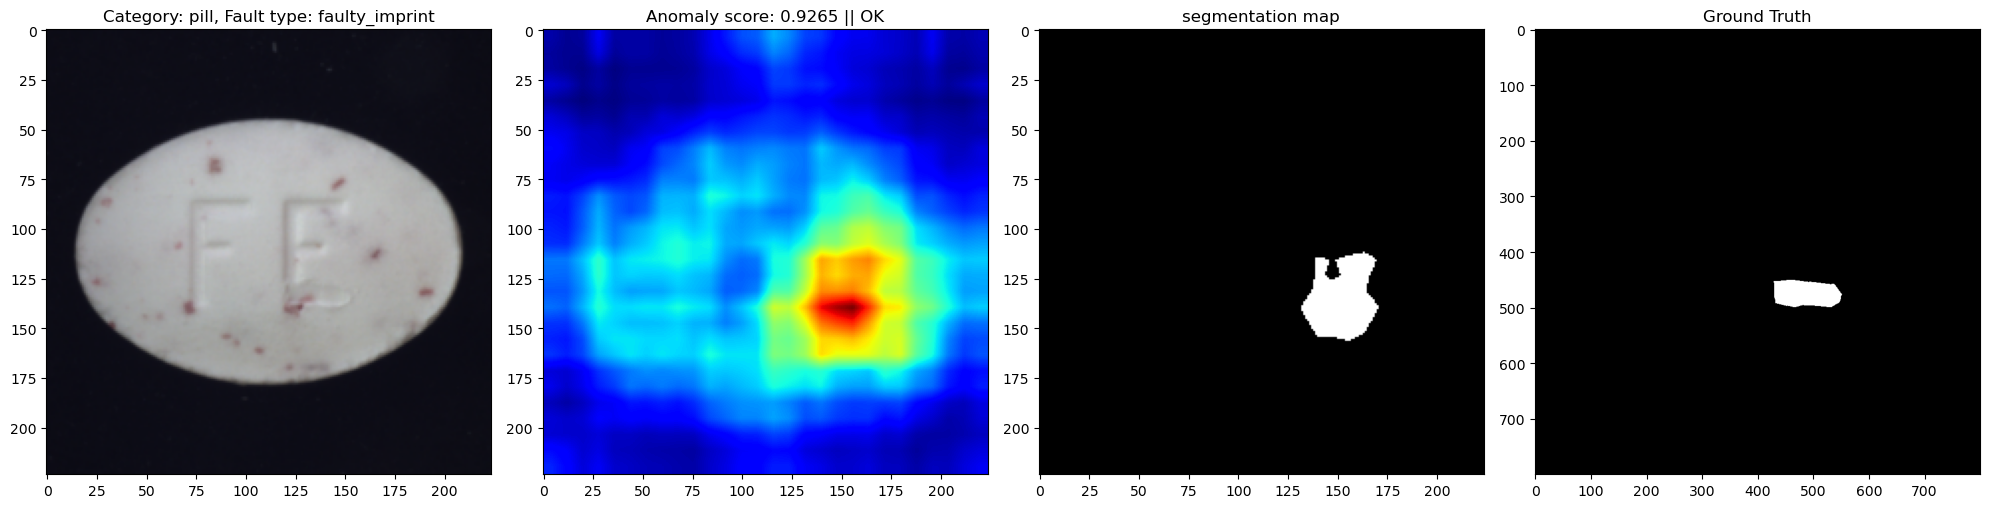

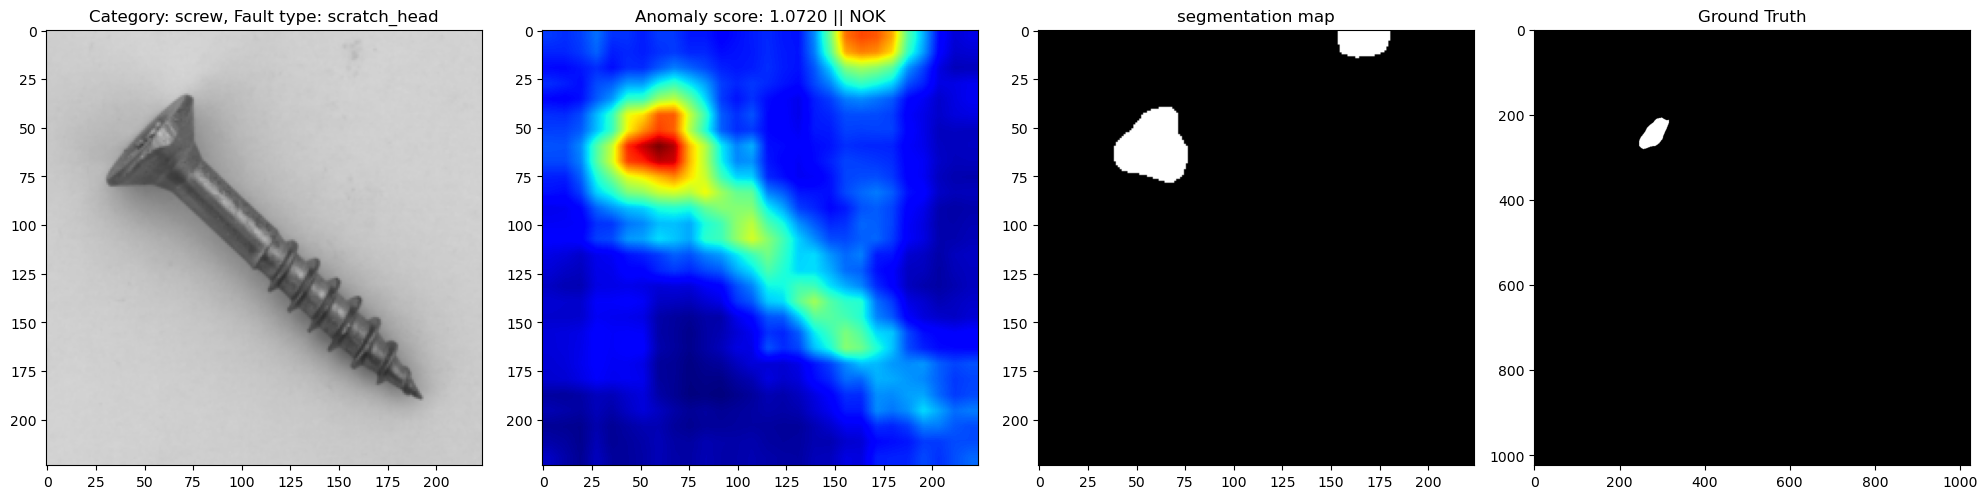

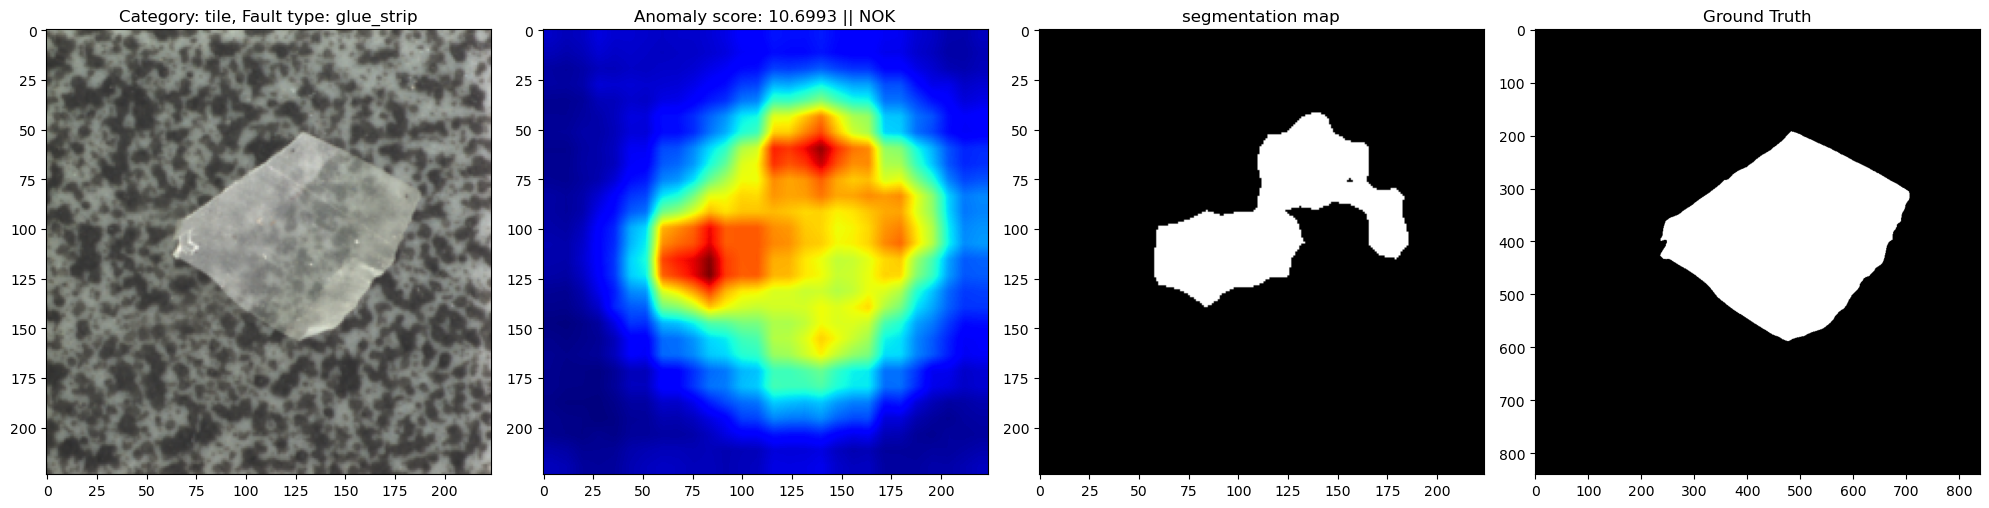

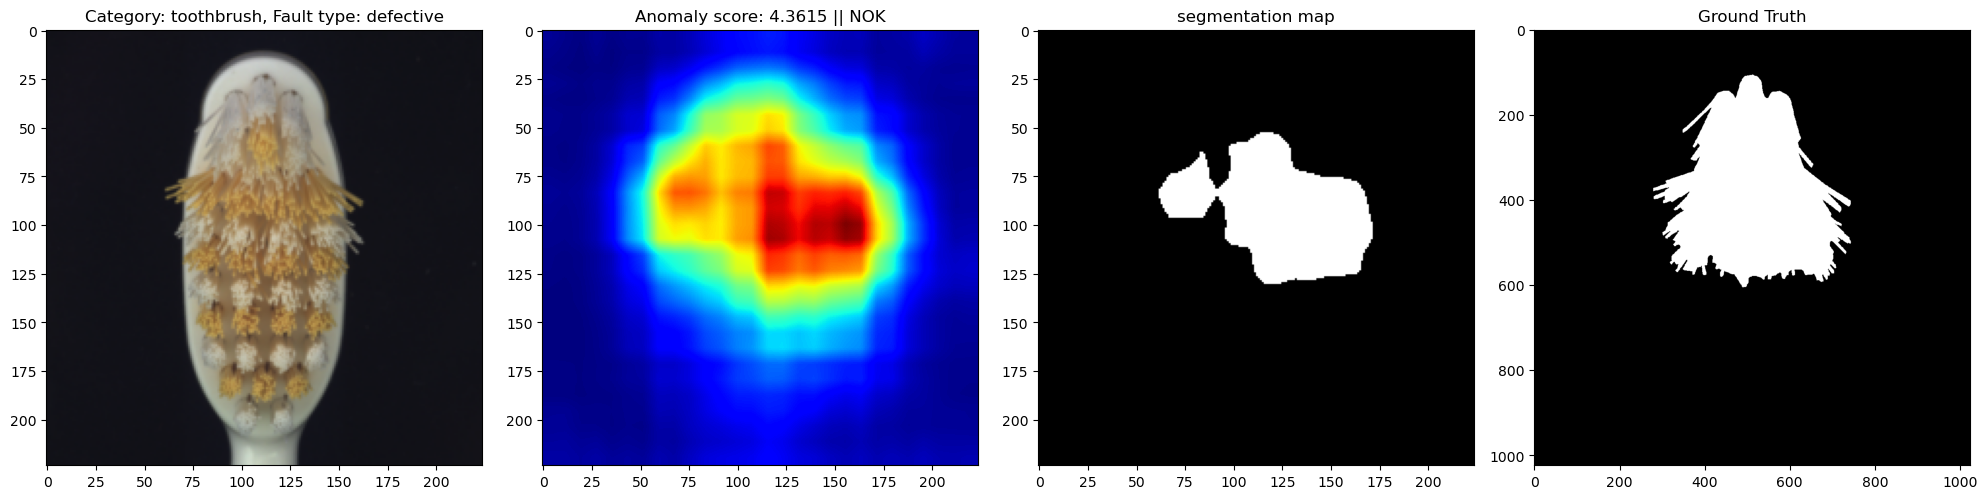

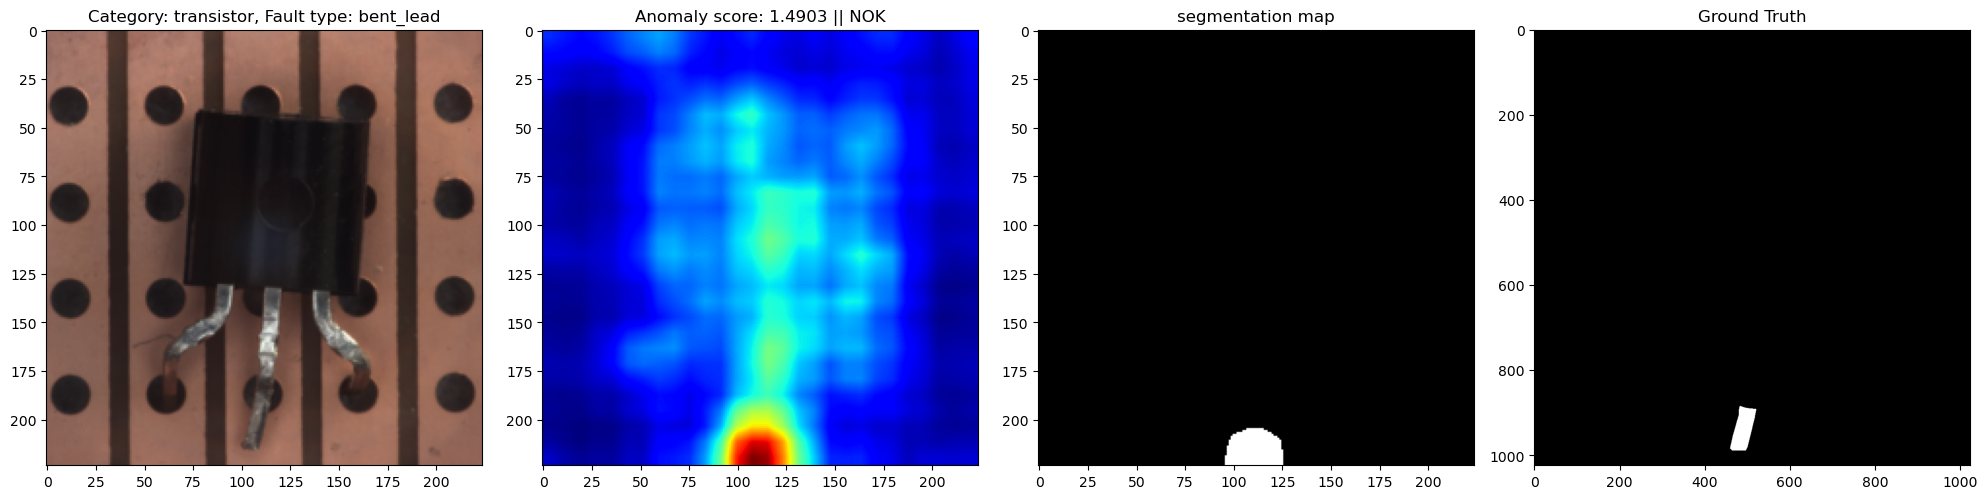

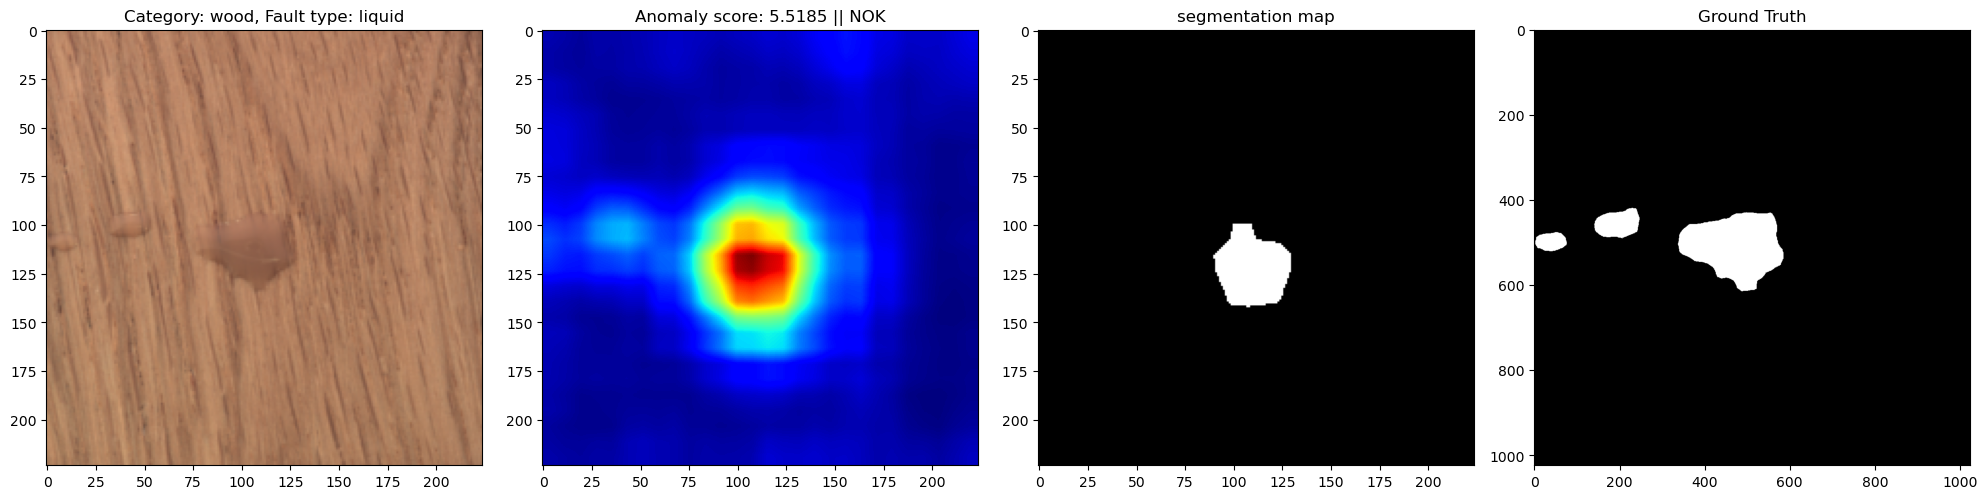

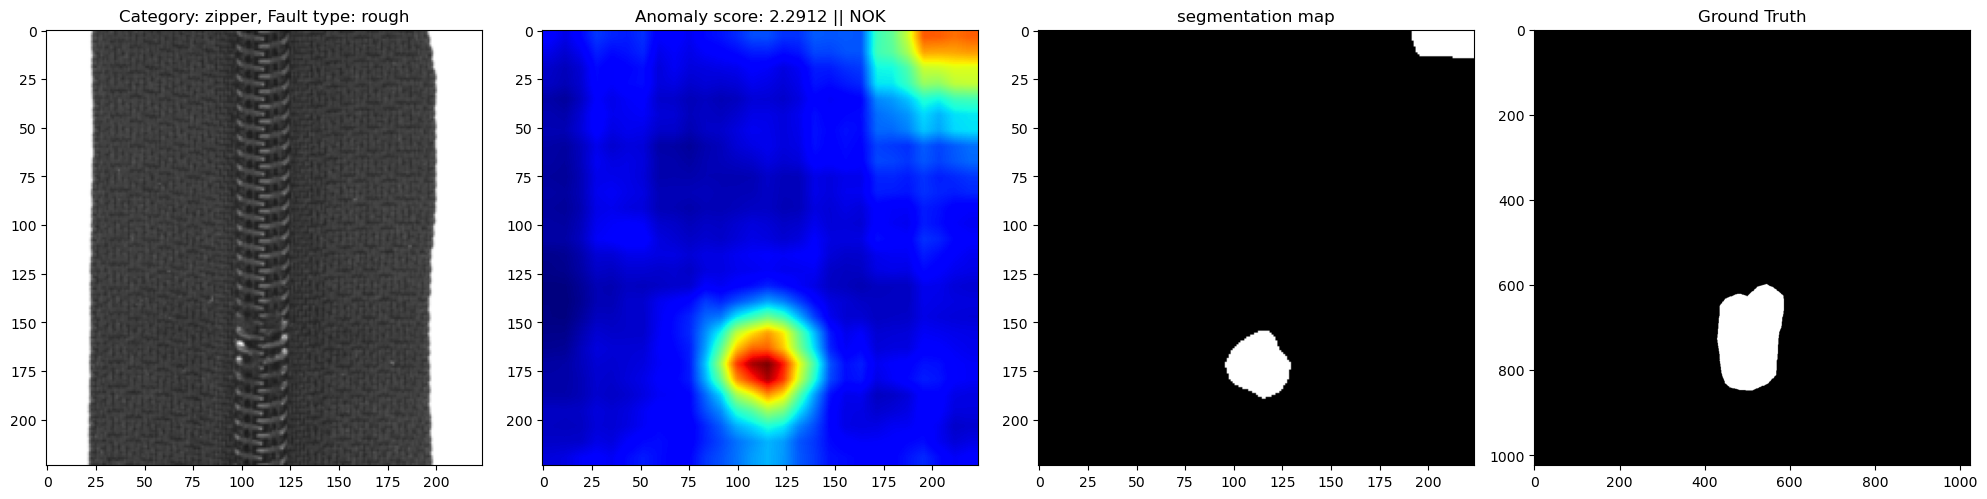

In [48]:
import cv2, time
from IPython.display import clear_output
import random

model.eval()
backbone.eval()

for category in categories[min_categories:max_categories]:
    test_path = Path(os.path.join(dataset_dir, category, 'test'))
    nok_images = [path for path in test_path.glob('*/*.png') if path.parts[-2] != 'good']
    
    random_nok_images = random.sample(nok_images, min(len(nok_images), 1))

    for path in random_nok_images:
        fault_type = path.parts[-2]
        image = Image.open(path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        test_image = transform(image).cuda().unsqueeze(0)

        with torch.no_grad():
            features = backbone(test_image)
            recon = loaded_models[category](features)

        segm_map = ((features - recon)**2).mean(axis=(1))
        y_score_image = decision_function(segm_map=segm_map)
        y_pred_image = 1 * (y_score_image >= best_thresholds[category])
        class_label = ['OK', 'NOK']

        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.title(f'Category: {category}, Fault type: {fault_type}')

        plt.subplot(1, 4, 2)
        heat_map = segm_map.squeeze().cpu().numpy()
        heat_map = cv2.resize(heat_map, (224, 224))
        plt.imshow(heat_map, cmap='jet', vmin=heat_map.min(), vmax=heat_map.max())
        plt.title(f'Anomaly score: {y_score_image[0].cpu().numpy() / best_thresholds[category]:0.4f} || {class_label[y_pred_image]}')

        # Highlight only red/orange/yellow (top range) in the segmentation
        plt.subplot(1, 4, 3)
        norm_heat_map = (heat_map - heat_map.min()) / (heat_map.max() - heat_map.min())
        highlight_mask = norm_heat_map >= 0.7
        plt.imshow(highlight_mask, cmap='gray')
        plt.title('segmentation map')

        # Load ground truth image if it exists
        gt_path = str(path).replace('test', 'ground_truth').replace('.png', '_mask.png')
        if os.path.exists(gt_path):
            gt_image = Image.open(gt_path).convert('L')  # Load as grayscale
            plt.subplot(1, 4, 4)
            plt.imshow(gt_image, cmap='gray')
            plt.title('Ground Truth')
        else:
            plt.subplot(1, 4, 4)
            plt.text(0.5, 0.5, 'No Ground Truth', horizontalalignment='center', verticalalignment='center')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
